<a href="https://colab.research.google.com/github/yohanesnuwara/computational-geophysics/blob/master/gravity/notebooks/fft_moving_average_2D_slice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier Transform and Moving Average Method for Gravity Regional and Residual Separation (on 2D slice)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
!git clone https://www.github.com/yohanesnuwara/computational-geophysics

Cloning into 'computational-geophysics'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 104 (delta 44), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (104/104), 83.05 KiB | 4.61 MiB/s, done.
Resolving deltas: 100% (44/44), done.


Data

In [0]:
data = np.loadtxt('/content/computational-geophysics/gravity/data/Gravity_UTM.txt')
utm_x = np.array(data[:,0])
utm_y = np.array(data[:,1])
CBA = np.array(data[:,2])

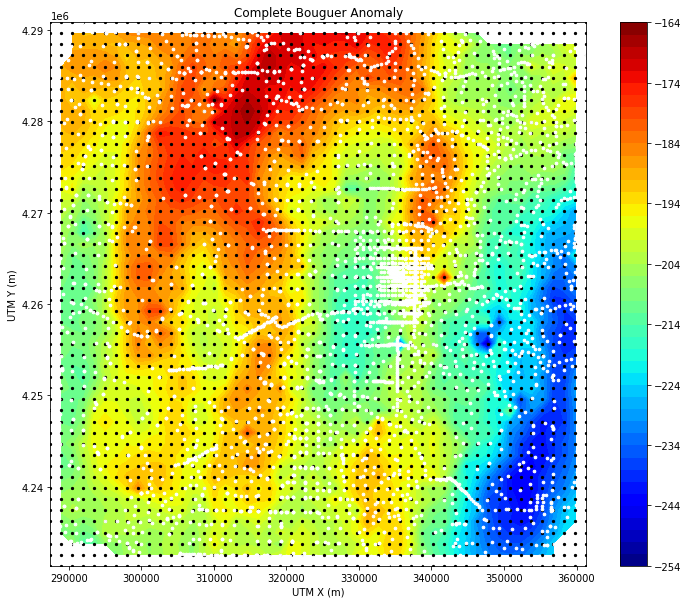

In [0]:
import scipy
from scipy.interpolate import griddata

xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)
# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi),method='cubic')

fig, ax = plt.subplots(figsize=(12,10))
# plot CBA contours
im = ax.contourf(xi,yi,zi,levels=50, cmap="jet")
ax.set_title('Complete Bouguer Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
fig.colorbar(im)

im = plt.scatter(xi, yi, s=5, color='black')

# plot stations WITH STATION NUMBERS, started from 0
n = np.arange(0,len(utm_x), 1)
ax.scatter(utm_x, utm_y, s=7, color='white')

# for i, txt in enumerate(n):
#     ax.annotate(txt, (utm_x[i], utm_y[i]), size=12)

## Southwest-Northeast Slice

<div>
<img src="https://user-images.githubusercontent.com/51282928/77561620-87a2f980-6ef1-11ea-995a-42b929bc8d3d.jpeg" width="400"/>
</div>

In [0]:
# SW-NE slice
x_slice = np.array(xi[0])
print('Coordinate slice in X direction:', x_slice)

y_slice = []
for k in range(len(x_slice)):
  yslice = yi[k][k]
  y_slice.append(float(yslice))
y_slice = np.array(y_slice)
print('Coordinate slice in Y direction:', y_slice)

g_slice = []
for k in range(len(x_slice)):
  gslice = zi[k][k]
  g_slice.append(float(gslice))
g_slice = np.array(g_slice)
print('CBA on slice:', g_slice)

Visualize the slice

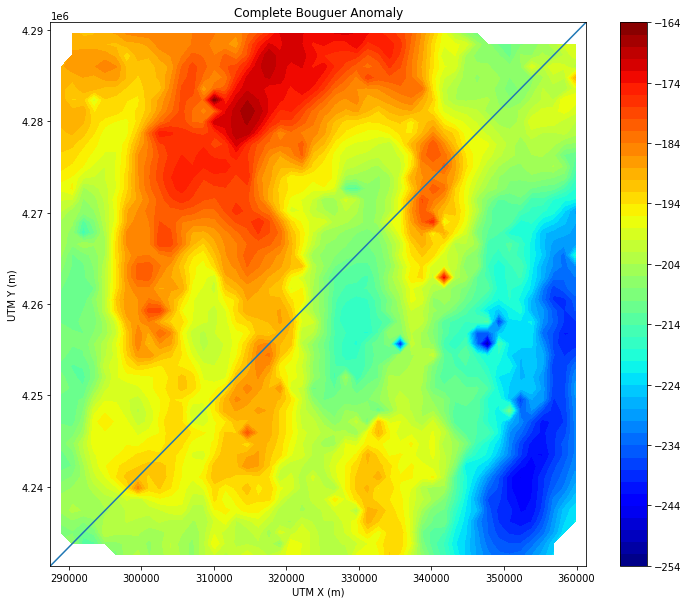

In [0]:
import scipy
from scipy.interpolate import griddata

xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)
# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi),method='cubic')

fig, ax = plt.subplots(figsize=(12,10))
# plot CBA contours
im = ax.contourf(xi,yi,zi,levels=50, cmap="jet")
ax.set_title('Complete Bouguer Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
fig.colorbar(im)

im = plt.plot(x_slice, y_slice)

### Data preparation for FFT

Create dataframe

In [0]:
data = pd.DataFrame({"UTM_X": x_slice, "UTM_Y": y_slice, "CBA": g_slice})
data.head(10)

,UTM_X,UTM_Y,CBA
0,287457.184700,4.231366e+06,NaN
1,288964.640341,4.232580e+06,NaN
2,290472.095982,4.233793e+06,-205.706931
3,291979.551622,4.235007e+06,-210.851841
4,293487.007263,4.236220e+06,-206.050330
5,294994.462904,4.237434e+06,-204.329496
6,296501.918545,4.238648e+06,-202.552934
7,298009.374186,4.239861e+06,-194.185966
8,299516.829827,4.241075e+06,-190.688002
9,301024.285467,4.242288e+06,-191.265982


Remove NaN from dataframe

In [0]:
# look up the number of rows with NaN data
print("Original size of data:", len(data), "rows")
print("How many data with NaN values?")
print(data.isnull().sum())

# drop rows with missing values
data.dropna(inplace=True)
# re-index dataframe
data = data.reset_index(drop=True)
print("NaN has successfully been deleted")
data.head(10)

Original size of data: 50 rows
How many data with NaN values?
UTM_X    0
UTM_Y    0
CBA      4
dtype: int64
NaN has successfully been deleted


,UTM_X,UTM_Y,CBA
0,290472.095982,4.233793e+06,-205.706931
1,291979.551622,4.235007e+06,-210.851841
2,293487.007263,4.236220e+06,-206.050330
3,294994.462904,4.237434e+06,-204.329496
4,296501.918545,4.238648e+06,-202.552934
5,298009.374186,4.239861e+06,-194.185966
6,299516.829827,4.241075e+06,-190.688002
7,301024.285467,4.242288e+06,-191.265982
8,302531.741108,4.243502e+06,-193.808854
9,304039.196749,4.244715e+06,-192.951010


Calculate interval on slice

In [0]:
# calculate distance on slice from the first point on slice
dist_x = np.array([j-i for i, j in zip(data.UTM_X[:-1], data.UTM_X[1:])])
dist_y = np.array([j-i for i, j in zip(data.UTM_Y[:-1], data.UTM_Y[1:])])
dist = np.sqrt((dist_x**2) + (dist_y**2))
dist = np.cumsum(dist)
dist = np.append(0, dist)

Put interval into dataframe

In [0]:
data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": dist})
data.head(10)

,UTM_X,UTM_Y,CBA,Interval
0,290472.095982,4.233793e+06,-205.706931,0.000000
1,291979.551622,4.235007e+06,-210.851841,1935.233113
2,293487.007263,4.236220e+06,-206.050330,3870.466226
3,294994.462904,4.237434e+06,-204.329496,5805.699339
4,296501.918545,4.238648e+06,-202.552934,7740.932452
5,298009.374186,4.239861e+06,-194.185966,9676.165564
6,299516.829827,4.241075e+06,-190.688002,11611.398677
7,301024.285467,4.242288e+06,-191.265982,13546.631790
8,302531.741108,4.243502e+06,-193.808854,15481.864903
9,304039.196749,4.244715e+06,-192.951010,17417.098016


### Fourier Transform

In [0]:
def dft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

fourier = np.fft.fft(data.CBA)
print(len(fourier))

46


In [0]:
imaginary = fourier.imag
real = fourier.real
absolute = np.sqrt((imaginary**2) + (real**2))
ln_abs = np.log(absolute)

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute
0,290472.095982,4.233793e+06,-205.706931,0.000000,-9120.325193+0.000000j,-9120.325193,0.000000,9120.325193,9.118261
1,291979.551622,4.235007e+06,-210.851841,1935.233113,-43.122577-49.620512j,-43.122577,-49.620512,65.740033,4.185708
2,293487.007263,4.236220e+06,-206.050330,3870.466226,-169.927169+16.671643j,-169.927169,16.671643,170.743042,5.140160
3,294994.462904,4.237434e+06,-204.329496,5805.699339,64.375228-140.527025j,64.375228,-140.527025,154.570420,5.040650
4,296501.918545,4.238648e+06,-202.552934,7740.932452,-27.320899+102.237874j,-27.320899,102.237874,105.825396,4.661791
5,298009.374186,4.239861e+06,-194.185966,9676.165564,1.735914+54.678935j,1.735914,54.678935,54.706483,4.001982
6,299516.829827,4.241075e+06,-190.688002,11611.398677,-3.862458+8.306323j,-3.862458,8.306323,9.160436,2.214894
7,301024.285467,4.242288e+06,-191.265982,13546.631790,13.704181+15.703535j,13.704181,15.703535,20.842399,3.036989
8,302531.741108,4.243502e+06,-193.808854,15481.864903,-0.503164+10.921766j,-0.503164,10.921766,10.933350,2.391818
9,304039.196749,4.244715e+06,-192.951010,17417.098016,1.828472+11.164287j,1.828472,11.164287,11.313028,2.425955


Compute sampling frequency

In [0]:
# compute freq sampling
interval_last = fourier_data.Interval.iloc[-1]
minus = interval_last - fourier_data.Interval.iloc[0]

f_s = 0 # initial freq sampling
f_sample = []
for i in range(0,len(fourier_data.CBA)-1):
  f_s = f_s + (1 / minus)
  f_sample.append(float(f_s))
f_sample = np.append(0, f_sample)

# put into dataframe
fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample
0,290472.095982,4.233793e+06,-205.706931,0.000000,-9120.325193+0.000000j,-9120.325193,0.000000,9120.325193,9.118261,0.000000
1,291979.551622,4.235007e+06,-210.851841,1935.233113,-43.122577-49.620512j,-43.122577,-49.620512,65.740033,4.185708,0.000011
2,293487.007263,4.236220e+06,-206.050330,3870.466226,-169.927169+16.671643j,-169.927169,16.671643,170.743042,5.140160,0.000023
3,294994.462904,4.237434e+06,-204.329496,5805.699339,64.375228-140.527025j,64.375228,-140.527025,154.570420,5.040650,0.000034
4,296501.918545,4.238648e+06,-202.552934,7740.932452,-27.320899+102.237874j,-27.320899,102.237874,105.825396,4.661791,0.000046
5,298009.374186,4.239861e+06,-194.185966,9676.165564,1.735914+54.678935j,1.735914,54.678935,54.706483,4.001982,0.000057
6,299516.829827,4.241075e+06,-190.688002,11611.398677,-3.862458+8.306323j,-3.862458,8.306323,9.160436,2.214894,0.000069
7,301024.285467,4.242288e+06,-191.265982,13546.631790,13.704181+15.703535j,13.704181,15.703535,20.842399,3.036989,0.000080
8,302531.741108,4.243502e+06,-193.808854,15481.864903,-0.503164+10.921766j,-0.503164,10.921766,10.933350,2.391818,0.000092
9,304039.196749,4.244715e+06,-192.951010,17417.098016,1.828472+11.164287j,1.828472,11.164287,11.313028,2.425955,0.000103


Wavenumber

In [0]:
k = 2 * np.pi * f_sample

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample, "Wavenumber": k})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample,Wavenumber
0,290472.095982,4.233793e+06,-205.706931,0.000000,-9120.325193+0.000000j,-9120.325193,0.000000,9120.325193,9.118261,0.000000,0.000000
1,291979.551622,4.235007e+06,-210.851841,1935.233113,-43.122577-49.620512j,-43.122577,-49.620512,65.740033,4.185708,0.000011,0.000072
2,293487.007263,4.236220e+06,-206.050330,3870.466226,-169.927169+16.671643j,-169.927169,16.671643,170.743042,5.140160,0.000023,0.000144
3,294994.462904,4.237434e+06,-204.329496,5805.699339,64.375228-140.527025j,64.375228,-140.527025,154.570420,5.040650,0.000034,0.000216
4,296501.918545,4.238648e+06,-202.552934,7740.932452,-27.320899+102.237874j,-27.320899,102.237874,105.825396,4.661791,0.000046,0.000289
5,298009.374186,4.239861e+06,-194.185966,9676.165564,1.735914+54.678935j,1.735914,54.678935,54.706483,4.001982,0.000057,0.000361
6,299516.829827,4.241075e+06,-190.688002,11611.398677,-3.862458+8.306323j,-3.862458,8.306323,9.160436,2.214894,0.000069,0.000433
7,301024.285467,4.242288e+06,-191.265982,13546.631790,13.704181+15.703535j,13.704181,15.703535,20.842399,3.036989,0.000080,0.000505
8,302531.741108,4.243502e+06,-193.808854,15481.864903,-0.503164+10.921766j,-0.503164,10.921766,10.933350,2.391818,0.000092,0.000577
9,304039.196749,4.244715e+06,-192.951010,17417.098016,1.828472+11.164287j,1.828472,11.164287,11.313028,2.425955,0.000103,0.000649


Plot Spectrum

Text(0, 0.5, 'ln(absolute)')

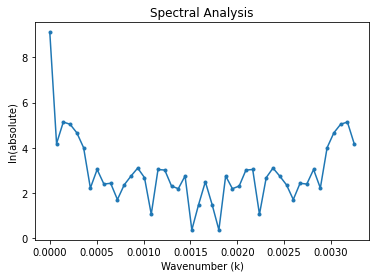

In [0]:
plt.plot(k, ln_abs, '.-')
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Cut-off Regional, Residual, Noise from Spectra

Text(0, 0.5, 'ln(absolute)')

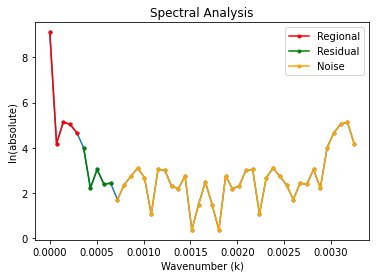

In [0]:
# guess the cutoff !!!
reg_cut = 5
res_cut = 10

k_reg_cut = k[:reg_cut]; ln_reg_cut = ln_abs[:reg_cut]
k_res_cut = k[reg_cut:res_cut]; ln_res_cut = ln_abs[reg_cut:res_cut]
k_noise_cut = k[res_cut:]; ln_noise_cut = ln_abs[res_cut:]

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')

plt.legend((p1[0], p2[0], p3[0]), ['Regional', 'Residual', 'Noise'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Determine window for Moving Average

#### Regression Function

In [0]:
def simple_linear_regression_traditional(x, y):
  import numpy as np
  x = np.array(x); y = np.array(y)
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  err_x = x - mean_x
  err_y = y - mean_y
  err_mult = err_x * err_y
  numerator = np.sum(err_mult)
  err_x_squared = err_x**2
  denominator = np.sum(err_x_squared)
  B1 = numerator / denominator
  B0 = mean_y - B1 * mean_x

  return(B0, B1) # B0 intercept, B1 gradient

#### Regression, calculate Cutt-off Frequency, calculate Window

In [0]:
#Regional Zone
B0, B1=simple_linear_regression_traditional(k_reg_cut, ln_reg_cut)

#Residual Zone
B2, B3=simple_linear_regression_traditional(k_res_cut, ln_res_cut)

# cut-off
cut_off = (B2-B0)/(B1-B3)

# window
windows = 2*np.pi/((fourier_data.Interval[3]-fourier_data.Interval[2])*cut_off)

print("Calculated window: ",windows, "\n")
print("Intercept for Regional Zone: ",B0)
print("Gradient for Regional Zone: ",B1)
print("Intercept for Residual Zone: ",B2)
print("Gradient for Residual Zone: ",B3)
print("Cut-off frequency: ",cut_off)

Calculated window:  9.758088793639198 

Intercept for Regional Zone:  7.240913512543074
Gradient for Regional Zone:  -11168.455672704733
Intercept for Residual Zone:  4.896918956952932
Gradient for Residual Zone:  -4123.556491682597
Cut-off frequency:  0.00033272222857418576


#### Windowing rule

Window must be an **odd number**. Rule and example:

* 1.25 rounded to 1. 1 is odd, so window = 1
* 1.75 rounded to 2. 2 is even, so window = 2 - 1 = 1
* 2.25 rounded to 2. 2 is even, so window = 2 + 1 = 3
* 2.75 rounded to 3. 3 is even, so window = 3

In [0]:
rounded = np.round(windows)

if rounded % 2 == 0:
  # even
  if (rounded - windows) > 0:
    window = rounded - 1
  if (rounded - windows) < 0:
    window = rounded + 1
else:
  # odd
  window = rounded

print("Selected odd window is:", window)

Selected odd window is: 9.0


#### Plot regression of spectrum

Text(0, 0.5, 'ln(absolute)')

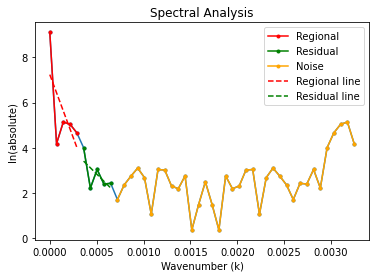

In [0]:
y_reg = B0 + B1 * k_reg_cut
y_res = B2 + B3 * k_res_cut

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')
p4 = plt.plot(k_reg_cut, y_reg, '--', color='red')
p5 = plt.plot(k_res_cut, y_res, '--', color='green')

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ['Regional', 'Residual', 'Noise', 'Regional line', 'Residual line'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Moving Average (Regional Separation)

In [0]:
regional = fourier_data.CBA.rolling(window=(int(window))).mean()

### Residual Separation

In [0]:
residual = fourier_data.CBA - regional

### Print dataframe

In [0]:
mva = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "Interval": data.Interval, "CBA": data.CBA, "Regional": regional, "Residual": residual})
mva.head(20)

,UTM_X,UTM_Y,Interval,CBA,Regional,Residual
0,290472.095982,4.233793e+06,0.000000,-205.706931,NaN,NaN
1,291979.551622,4.235007e+06,1935.233113,-210.851841,NaN,NaN
2,293487.007263,4.236220e+06,3870.466226,-206.050330,NaN,NaN
3,294994.462904,4.237434e+06,5805.699339,-204.329496,NaN,NaN
4,296501.918545,4.238648e+06,7740.932452,-202.552934,NaN,NaN
5,298009.374186,4.239861e+06,9676.165564,-194.185966,NaN,NaN
6,299516.829827,4.241075e+06,11611.398677,-190.688002,NaN,NaN
7,301024.285467,4.242288e+06,13546.631790,-191.265982,NaN,NaN
8,302531.741108,4.243502e+06,15481.864903,-193.808854,-199.937815,6.128961
9,304039.196749,4.244715e+06,17417.098016,-192.951010,-198.520491,5.569481


### Plot CBA, Regional, Residual Slice

Text(0, 0.5, 'Regional anomaly (mgal)')

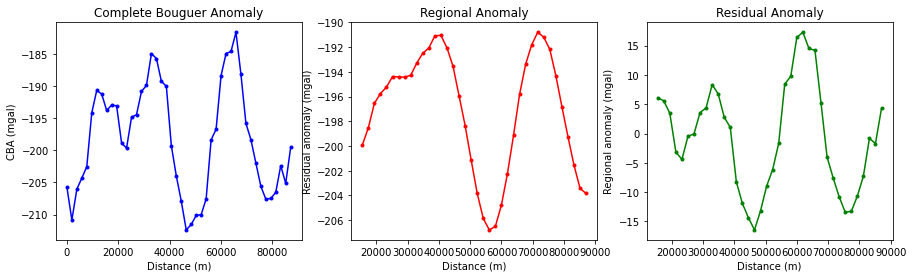

In [0]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(mva.Interval, mva.CBA, '.-', color='blue')
plt.title('Complete Bouguer Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('CBA (mgal)')
plt.subplot(1,3,2)
plt.plot(mva.Interval, mva.Regional, '.-', color='red')
plt.title('Regional Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Residual anomaly (mgal)')
plt.subplot(1,3,3)
plt.plot(mva.Interval, mva.Residual, '.-', color='green')
plt.title('Residual Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Regional anomaly (mgal)')

### Save data into CSV

In [0]:
mva.to_csv('/content/fft_SW-NE.csv') 

## Southeast-Nortwest Slice

<div>
<img src="https://user-images.githubusercontent.com/51282928/77572745-19b2fe00-6f02-11ea-8512-1d2ab1b5fdfc.jpeg" width="400"/>
</div>

Clue

In [0]:
a = [1,2,3,4,5]
for i, j in zip(reversed(range(len(a))), (range(len(a)))):
  print(a[i], a[j])

5 1
4 2
3 3
2 4
1 5


In [0]:
# SE-NW slice
x_slice = np.array(xi[0])
print('Coordinate slice in X direction:', x_slice)

y_slice = []
for k, j in zip(reversed(range(len(x_slice))), (range(len(x_slice)))):
  yslice = yi[k][j]
  y_slice.append(float(yslice))
y_slice = np.array(y_slice)
print('Coordinate slice in Y direction:', y_slice)

g_slice = []
for k, j in zip(reversed(range(len(x_slice))), (range(len(x_slice)))):
  gslice = zi[k][j]
  g_slice.append(float(gslice))
g_slice = np.array(g_slice)
print('CBA on slice:', g_slice)

Coordinate slice in X direction: [287457.1847     288964.64034082 290472.09598163 291979.55162245
 293487.00726327 294994.46290408 296501.9185449  298009.37418571
 299516.82982653 301024.28546735 302531.74110816 304039.19674898
 305546.6523898  307054.10803061 308561.56367143 310069.01931224
 311576.47495306 313083.93059388 314591.38623469 316098.84187551
 317606.29751633 319113.75315714 320621.20879796 322128.66443878
 323636.12007959 325143.57572041 326651.03136122 328158.48700204
 329665.94264286 331173.39828367 332680.85392449 334188.30956531
 335695.76520612 337203.22084694 338710.67648776 340218.13212857
 341725.58776939 343233.0434102  344740.49905102 346247.95469184
 347755.41033265 349262.86597347 350770.32161429 352277.7772551
 353785.23289592 355292.68853673 356800.14417755 358307.59981837
 359815.05545918 361322.5111    ]
Coordinate slice in Y direction: [4290830.223      4289616.67255102 4288403.12210204 4287189.57165306
 4285976.02120408 4284762.4707551  4283548.92030612 

Visualize the slice

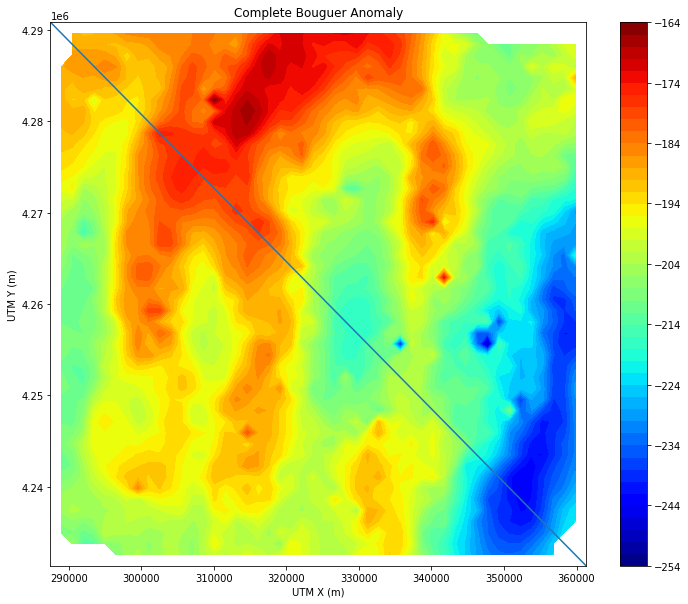

In [0]:
import scipy
from scipy.interpolate import griddata

xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)
# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi),method='cubic')

fig, ax = plt.subplots(figsize=(12,10))
# plot CBA contours
im = ax.contourf(xi,yi,zi,levels=50, cmap="jet")
ax.set_title('Complete Bouguer Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
fig.colorbar(im)

im = plt.plot(x_slice, y_slice)

### Data preparation for FFT

Create dataframe

In [0]:
data = pd.DataFrame({"UTM_X": x_slice, "UTM_Y": y_slice, "CBA": g_slice})
data.head(10)

,UTM_X,UTM_Y,CBA
0,287457.184700,4.290830e+06,NaN
1,288964.640341,4.289617e+06,NaN
2,290472.095982,4.288403e+06,-188.800447
3,291979.551622,4.287190e+06,-187.100593
4,293487.007263,4.285976e+06,-186.210323
5,294994.462904,4.284762e+06,-187.247706
6,296501.918545,4.283549e+06,-190.929077
7,298009.374186,4.282335e+06,-193.911992
8,299516.829827,4.281122e+06,-193.717310
9,301024.285467,4.279908e+06,-188.310866


Remove NaN from dataframe

In [0]:
# look up the number of rows with NaN data
print("Original size of data:", len(data), "rows")
print("How many data with NaN values?")
print(data.isnull().sum())

# drop rows with missing values
data.dropna(inplace=True)
# re-index dataframe
data = data.reset_index(drop=True)
print("NaN has successfully been deleted")
data.head(10)

Original size of data: 50 rows
How many data with NaN values?
UTM_X    0
UTM_Y    0
CBA      5
dtype: int64
NaN has successfully been deleted


,UTM_X,UTM_Y,CBA
0,290472.095982,4.288403e+06,-188.800447
1,291979.551622,4.287190e+06,-187.100593
2,293487.007263,4.285976e+06,-186.210323
3,294994.462904,4.284762e+06,-187.247706
4,296501.918545,4.283549e+06,-190.929077
5,298009.374186,4.282335e+06,-193.911992
6,299516.829827,4.281122e+06,-193.717310
7,301024.285467,4.279908e+06,-188.310866
8,302531.741108,4.278695e+06,-174.907887
9,304039.196749,4.277481e+06,-177.405821


Calculate interval on slice

In [0]:
# calculate distance on slice from the first point on slice
dist_x = np.array([j-i for i, j in zip(data.UTM_X[:-1], data.UTM_X[1:])])
dist_y = np.array([j-i for i, j in zip(data.UTM_Y[:-1], data.UTM_Y[1:])])
dist = np.sqrt((dist_x**2) + (dist_y**2))
dist = np.cumsum(dist)
dist = np.append(0, dist)

Put interval into dataframe

In [0]:
data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": dist})
data.head(10)

,UTM_X,UTM_Y,CBA,Interval
0,290472.095982,4.288403e+06,-188.800447,0.000000
1,291979.551622,4.287190e+06,-187.100593,1935.233113
2,293487.007263,4.285976e+06,-186.210323,3870.466226
3,294994.462904,4.284762e+06,-187.247706,5805.699339
4,296501.918545,4.283549e+06,-190.929077,7740.932452
5,298009.374186,4.282335e+06,-193.911992,9676.165564
6,299516.829827,4.281122e+06,-193.717310,11611.398677
7,301024.285467,4.279908e+06,-188.310866,13546.631790
8,302531.741108,4.278695e+06,-174.907887,15481.864903
9,304039.196749,4.277481e+06,-177.405821,17417.098016


### Fourier Transform

In [0]:
def dft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

fourier = np.fft.fft(data.CBA)
print(len(fourier))

45


In [0]:
imaginary = fourier.imag
real = fourier.real
absolute = np.sqrt((imaginary**2) + (real**2))
ln_abs = np.log(absolute)

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute
0,290472.095982,4.288403e+06,-188.800447,0.000000,-9046.233496+0.000000j,-9046.233496,0.000000,9046.233496,9.110104
1,291979.551622,4.287190e+06,-187.100593,1935.233113,-131.689197-478.492136j,-131.689197,-478.492136,496.282953,6.207146
2,293487.007263,4.285976e+06,-186.210323,3870.466226,-192.537063-117.345005j,-192.537063,-117.345005,225.478094,5.418223
3,294994.462904,4.284762e+06,-187.247706,5805.699339,108.134905-220.843223j,108.134905,-220.843223,245.896089,5.504909
4,296501.918545,4.283549e+06,-190.929077,7740.932452,84.819046-48.157236j,84.819046,-48.157236,97.536608,4.580228
5,298009.374186,4.282335e+06,-193.911992,9676.165564,97.310883-87.276234j,97.310883,-87.276234,130.715527,4.873023
6,299516.829827,4.281122e+06,-193.717310,11611.398677,54.499400-55.217097j,54.499400,-55.217097,77.582938,4.351348
7,301024.285467,4.279908e+06,-188.310866,13546.631790,-0.424804-31.375705j,-0.424804,-31.375705,31.378580,3.446126
8,302531.741108,4.278695e+06,-174.907887,15481.864903,2.007202-28.387284j,2.007202,-28.387284,28.458158,3.348435
9,304039.196749,4.277481e+06,-177.405821,17417.098016,7.264663-12.286222j,7.264663,-12.286222,14.273282,2.658389


Compute sampling frequency

In [0]:
# compute freq sampling
interval_last = fourier_data.Interval.iloc[-1]
minus = interval_last - fourier_data.Interval.iloc[0]

f_s = 0 # initial freq sampling
f_sample = []
for i in range(0,len(fourier_data.CBA)-1):
  f_s = f_s + (1 / minus)
  f_sample.append(float(f_s))
f_sample = np.append(0, f_sample)

# put into dataframe
fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample
0,290472.095982,4.288403e+06,-188.800447,0.000000,-9046.233496+0.000000j,-9046.233496,0.000000,9046.233496,9.110104,0.000000
1,291979.551622,4.287190e+06,-187.100593,1935.233113,-131.689197-478.492136j,-131.689197,-478.492136,496.282953,6.207146,0.000012
2,293487.007263,4.285976e+06,-186.210323,3870.466226,-192.537063-117.345005j,-192.537063,-117.345005,225.478094,5.418223,0.000023
3,294994.462904,4.284762e+06,-187.247706,5805.699339,108.134905-220.843223j,108.134905,-220.843223,245.896089,5.504909,0.000035
4,296501.918545,4.283549e+06,-190.929077,7740.932452,84.819046-48.157236j,84.819046,-48.157236,97.536608,4.580228,0.000047
5,298009.374186,4.282335e+06,-193.911992,9676.165564,97.310883-87.276234j,97.310883,-87.276234,130.715527,4.873023,0.000059
6,299516.829827,4.281122e+06,-193.717310,11611.398677,54.499400-55.217097j,54.499400,-55.217097,77.582938,4.351348,0.000070
7,301024.285467,4.279908e+06,-188.310866,13546.631790,-0.424804-31.375705j,-0.424804,-31.375705,31.378580,3.446126,0.000082
8,302531.741108,4.278695e+06,-174.907887,15481.864903,2.007202-28.387284j,2.007202,-28.387284,28.458158,3.348435,0.000094
9,304039.196749,4.277481e+06,-177.405821,17417.098016,7.264663-12.286222j,7.264663,-12.286222,14.273282,2.658389,0.000106


Wavenumber

In [0]:
k = 2 * np.pi * f_sample

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample, "Wavenumber": k})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample,Wavenumber
0,290472.095982,4.288403e+06,-188.800447,0.000000,-9046.233496+0.000000j,-9046.233496,0.000000,9046.233496,9.110104,0.000000,0.000000
1,291979.551622,4.287190e+06,-187.100593,1935.233113,-131.689197-478.492136j,-131.689197,-478.492136,496.282953,6.207146,0.000012,0.000074
2,293487.007263,4.285976e+06,-186.210323,3870.466226,-192.537063-117.345005j,-192.537063,-117.345005,225.478094,5.418223,0.000023,0.000148
3,294994.462904,4.284762e+06,-187.247706,5805.699339,108.134905-220.843223j,108.134905,-220.843223,245.896089,5.504909,0.000035,0.000221
4,296501.918545,4.283549e+06,-190.929077,7740.932452,84.819046-48.157236j,84.819046,-48.157236,97.536608,4.580228,0.000047,0.000295
5,298009.374186,4.282335e+06,-193.911992,9676.165564,97.310883-87.276234j,97.310883,-87.276234,130.715527,4.873023,0.000059,0.000369
6,299516.829827,4.281122e+06,-193.717310,11611.398677,54.499400-55.217097j,54.499400,-55.217097,77.582938,4.351348,0.000070,0.000443
7,301024.285467,4.279908e+06,-188.310866,13546.631790,-0.424804-31.375705j,-0.424804,-31.375705,31.378580,3.446126,0.000082,0.000517
8,302531.741108,4.278695e+06,-174.907887,15481.864903,2.007202-28.387284j,2.007202,-28.387284,28.458158,3.348435,0.000094,0.000590
9,304039.196749,4.277481e+06,-177.405821,17417.098016,7.264663-12.286222j,7.264663,-12.286222,14.273282,2.658389,0.000106,0.000664


Plot Spectrum

Text(0, 0.5, 'ln(absolute)')

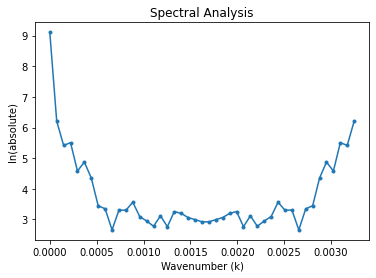

In [0]:
plt.plot(k, ln_abs, '.-')
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Cut-off Regional, Residual, Noise from Spectra

Text(0, 0.5, 'ln(absolute)')

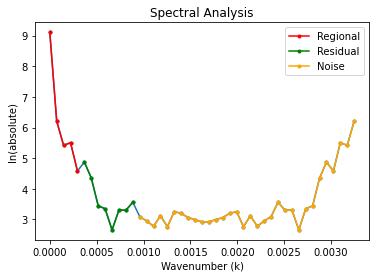

In [0]:
# guess the cutoff !!!
reg_cut = 5
res_cut = 13

k_reg_cut = k[:reg_cut]; ln_reg_cut = ln_abs[:reg_cut]
k_res_cut = k[reg_cut:res_cut]; ln_res_cut = ln_abs[reg_cut:res_cut]
k_noise_cut = k[res_cut:]; ln_noise_cut = ln_abs[res_cut:]

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')

plt.legend((p1[0], p2[0], p3[0]), ['Regional', 'Residual', 'Noise'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Determine window for Moving Average

#### Regression Function

In [0]:
def simple_linear_regression_traditional(x, y):
  import numpy as np
  x = np.array(x); y = np.array(y)
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  err_x = x - mean_x
  err_y = y - mean_y
  err_mult = err_x * err_y
  numerator = np.sum(err_mult)
  err_x_squared = err_x**2
  denominator = np.sum(err_x_squared)
  B1 = numerator / denominator
  B0 = mean_y - B1 * mean_x

  return(B0, B1) # B0 intercept, B1 gradient

#### Regression, calculate Cutt-off Frequency, calculate Window

In [0]:
#Regional Zone
B0, B1=simple_linear_regression_traditional(k_reg_cut, ln_reg_cut)

#Residual Zone
B2, B3=simple_linear_regression_traditional(k_res_cut, ln_res_cut)

# cut-off
cut_off = (B2-B0)/(B1-B3)

# window
windows = 2*np.pi/((fourier_data.Interval[3]-fourier_data.Interval[2])*cut_off)

print("Calculated window: ",windows, "\n")
print("Intercept for Regional Zone: ",B0)
print("Gradient for Regional Zone: ",B1)
print("Intercept for Residual Zone: ",B2)
print("Gradient for Residual Zone: ",B3)
print("Cut-off frequency: ",cut_off)

Calculated window:  11.848427757919138 

Intercept for Regional Zone:  8.11651979672154
Gradient for Regional Zone:  -13229.529997343852
Intercept for Residual Zone:  5.178301300542369
Gradient for Residual Zone:  -2506.9762633728965
Cut-off frequency:  0.00027402226830259413


#### Windowing rule

Window must be an **odd number**. Rule and example:

* 1.25 rounded to 1. 1 is odd, so window = 1
* 1.75 rounded to 2. 2 is even, so window = 2 - 1 = 1
* 2.25 rounded to 2. 2 is even, so window = 2 + 1 = 3
* 2.75 rounded to 3. 3 is even, so window = 3

In [0]:
rounded = np.round(windows)

if rounded % 2 == 0:
  # even
  if (rounded - windows) > 0:
    window = rounded - 1
  if (rounded - windows) < 0:
    window = rounded + 1
else:
  # odd
  window = rounded

print("Selected odd window is:", window)

Selected odd window is: 11.0


#### Plot regression of spectrum

Text(0, 0.5, 'ln(absolute)')

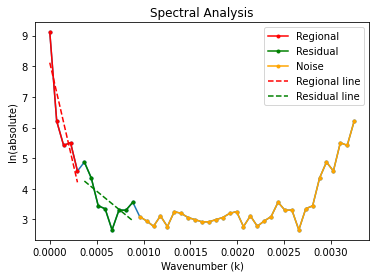

In [0]:
y_reg = B0 + B1 * k_reg_cut
y_res = B2 + B3 * k_res_cut

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')
p4 = plt.plot(k_reg_cut, y_reg, '--', color='red')
p5 = plt.plot(k_res_cut, y_res, '--', color='green')

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ['Regional', 'Residual', 'Noise', 'Regional line', 'Residual line'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Moving Average (Regional Separation)

In [0]:
regional = fourier_data.CBA.rolling(window=(int(window))).mean()

### Residual Separation

In [0]:
residual = fourier_data.CBA - regional

### Print dataframe

In [0]:
mva = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "Interval": data.Interval, "CBA": data.CBA, "Regional": regional, "Residual": residual})
mva.head(20)

,UTM_X,UTM_Y,Interval,CBA,Regional,Residual
0,290472.095982,4.288403e+06,0.000000,-188.800447,NaN,NaN
1,291979.551622,4.287190e+06,1935.233113,-187.100593,NaN,NaN
2,293487.007263,4.285976e+06,3870.466226,-186.210323,NaN,NaN
3,294994.462904,4.284762e+06,5805.699339,-187.247706,NaN,NaN
4,296501.918545,4.283549e+06,7740.932452,-190.929077,NaN,NaN
5,298009.374186,4.282335e+06,9676.165564,-193.911992,NaN,NaN
6,299516.829827,4.281122e+06,11611.398677,-193.717310,NaN,NaN
7,301024.285467,4.279908e+06,13546.631790,-188.310866,NaN,NaN
8,302531.741108,4.278695e+06,15481.864903,-174.907887,NaN,NaN
9,304039.196749,4.277481e+06,17417.098016,-177.405821,NaN,NaN


### Plot CBA, Regional, Residual Slice

Text(0, 0.5, 'Regional anomaly (mgal)')

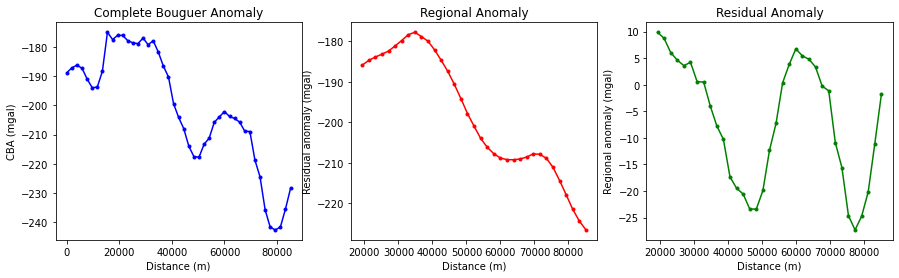

In [0]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(mva.Interval, mva.CBA, '.-', color='blue')
plt.title('Complete Bouguer Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('CBA (mgal)')
plt.subplot(1,3,2)
plt.plot(mva.Interval, mva.Regional, '.-', color='red')
plt.title('Regional Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Residual anomaly (mgal)')
plt.subplot(1,3,3)
plt.plot(mva.Interval, mva.Residual, '.-', color='green')
plt.title('Residual Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Regional anomaly (mgal)')

### Save data into CSV

In [0]:
mva.to_csv('/content/fft_SE-NW.csv') 

## East-West Slice 1

<div>
<img src="https://user-images.githubusercontent.com/51282928/77562687-e9179800-6ef2-11ea-8893-01805aa2db39.jpeg" width="400"/>
</div>

In [0]:
# E-W slice
x_slice = xi[10]
print('Coordinate slice in X direction:', x_slice)

y_slice = yi[10]
print('Coordinate slice in Y direction:', y_slice)

g_slice = zi[10]
print('CBA on slice:', g_slice)

Coordinate slice in X direction: [287457.1847     288964.64034082 290472.09598163 291979.55162245
 293487.00726327 294994.46290408 296501.9185449  298009.37418571
 299516.82982653 301024.28546735 302531.74110816 304039.19674898
 305546.6523898  307054.10803061 308561.56367143 310069.01931224
 311576.47495306 313083.93059388 314591.38623469 316098.84187551
 317606.29751633 319113.75315714 320621.20879796 322128.66443878
 323636.12007959 325143.57572041 326651.03136122 328158.48700204
 329665.94264286 331173.39828367 332680.85392449 334188.30956531
 335695.76520612 337203.22084694 338710.67648776 340218.13212857
 341725.58776939 343233.0434102  344740.49905102 346247.95469184
 347755.41033265 349262.86597347 350770.32161429 352277.7772551
 353785.23289592 355292.68853673 356800.14417755 358307.59981837
 359815.05545918 361322.5111    ]
Coordinate slice in Y direction: [4243501.7554898 4243501.7554898 4243501.7554898 4243501.7554898
 4243501.7554898 4243501.7554898 4243501.7554898 4243501

Visualize the slice

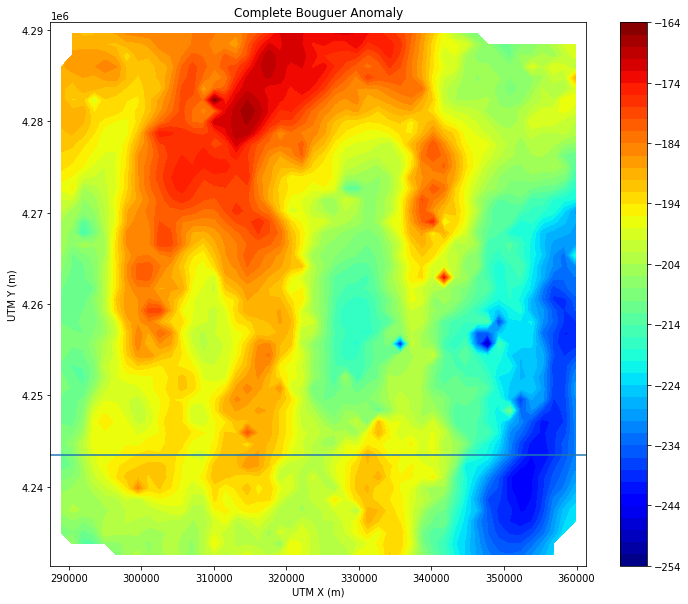

In [0]:
import scipy
from scipy.interpolate import griddata

xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)
# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi),method='cubic')

fig, ax = plt.subplots(figsize=(12,10))
# plot CBA contours
im = ax.contourf(xi,yi,zi,levels=50, cmap="jet")
ax.set_title('Complete Bouguer Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
fig.colorbar(im)

im = plt.plot(x_slice, y_slice)

### Data preparation for FFT

Create dataframe

In [0]:
data = pd.DataFrame({"UTM_X": x_slice, "UTM_Y": y_slice, "CBA": g_slice})
data.head(10)

,UTM_X,UTM_Y,CBA
0,287457.184700,4.243502e+06,NaN
1,288964.640341,4.243502e+06,-210.684510
2,290472.095982,4.243502e+06,-208.941836
3,291979.551622,4.243502e+06,-202.793251
4,293487.007263,4.243502e+06,-198.273014
5,294994.462904,4.243502e+06,-196.881126
6,296501.918545,4.243502e+06,-196.246887
7,298009.374186,4.243502e+06,-195.270077
8,299516.829827,4.243502e+06,-193.743529
9,301024.285467,4.243502e+06,-193.627887


Remove NaN from dataframe

In [0]:
# look up the number of rows with NaN data
print("Original size of data:", len(data), "rows")
print("How many data with NaN values?")
print(data.isnull().sum())

# drop rows with missing values
data.dropna(inplace=True)
# re-index dataframe
data = data.reset_index(drop=True)
print("NaN has successfully been deleted")
data.head(10)

Original size of data: 50 rows
How many data with NaN values?
UTM_X    0
UTM_Y    0
CBA      2
dtype: int64
NaN has successfully been deleted


,UTM_X,UTM_Y,CBA
0,288964.640341,4.243502e+06,-210.684510
1,290472.095982,4.243502e+06,-208.941836
2,291979.551622,4.243502e+06,-202.793251
3,293487.007263,4.243502e+06,-198.273014
4,294994.462904,4.243502e+06,-196.881126
5,296501.918545,4.243502e+06,-196.246887
6,298009.374186,4.243502e+06,-195.270077
7,299516.829827,4.243502e+06,-193.743529
8,301024.285467,4.243502e+06,-193.627887
9,302531.741108,4.243502e+06,-193.808854


Calculate interval on slice

In [0]:
# calculate distance on slice from the first point on slice
dist_x = np.array([j-i for i, j in zip(data.UTM_X[:-1], data.UTM_X[1:])])
dist_y = np.array([j-i for i, j in zip(data.UTM_Y[:-1], data.UTM_Y[1:])])
dist = np.sqrt((dist_x**2) + (dist_y**2))
dist = np.cumsum(dist)
dist = np.append(0, dist)

Put interval into dataframe

In [0]:
data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": dist})
data.head(10)

,UTM_X,UTM_Y,CBA,Interval
0,288964.640341,4.243502e+06,-210.684510,0.000000
1,290472.095982,4.243502e+06,-208.941836,1507.455641
2,291979.551622,4.243502e+06,-202.793251,3014.911282
3,293487.007263,4.243502e+06,-198.273014,4522.366922
4,294994.462904,4.243502e+06,-196.881126,6029.822563
5,296501.918545,4.243502e+06,-196.246887,7537.278204
6,298009.374186,4.243502e+06,-195.270077,9044.733845
7,299516.829827,4.243502e+06,-193.743529,10552.189486
8,301024.285467,4.243502e+06,-193.627887,12059.645127
9,302531.741108,4.243502e+06,-193.808854,13567.100767


### Fourier Transform

In [0]:
def dft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

fourier = np.fft.fft(data.CBA)
print(len(fourier))

48


In [0]:
imaginary = fourier.imag
real = fourier.real
absolute = np.sqrt((imaginary**2) + (real**2))
ln_abs = np.log(absolute)

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute
0,288964.640341,4.243502e+06,-210.684510,0.000000,-9821.482135+0.000000j,-9821.482135,0.000000,9821.482135,9.192327
1,290472.095982,4.243502e+06,-208.941836,1507.455641,-308.985756-269.773666j,-308.985756,-269.773666,410.182920,6.016603
2,291979.551622,4.243502e+06,-202.793251,3014.911282,-97.544120-252.202713j,-97.544120,-252.202713,270.409067,5.599936
3,293487.007263,4.243502e+06,-198.273014,4522.366922,74.980255-141.861200j,74.980255,-141.861200,160.457591,5.078030
4,294994.462904,4.243502e+06,-196.881126,6029.822563,-22.690501-68.429755j,-22.690501,-68.429755,72.093622,4.277966
5,296501.918545,4.243502e+06,-196.246887,7537.278204,46.161463+4.393970j,46.161463,4.393970,46.370116,3.836655
6,298009.374186,4.243502e+06,-195.270077,9044.733845,10.783669-41.659616j,10.783669,-41.659616,43.032675,3.761960
7,299516.829827,4.243502e+06,-193.743529,10552.189486,19.228350-17.484213j,19.228350,-17.484213,25.988981,3.257673
8,301024.285467,4.243502e+06,-193.627887,12059.645127,-7.512132+15.180542j,-7.512132,15.180542,16.937561,2.829534
9,302531.741108,4.243502e+06,-193.808854,13567.100767,-3.124581-5.821260j,-3.124581,-5.821260,6.606820,1.888102


Compute sampling frequency

In [0]:
# compute freq sampling
interval_last = fourier_data.Interval.iloc[-1]
minus = interval_last - fourier_data.Interval.iloc[0]

f_s = 0 # initial freq sampling
f_sample = []
for i in range(0,len(fourier_data.CBA)-1):
  f_s = f_s + (1 / minus)
  f_sample.append(float(f_s))
f_sample = np.append(0, f_sample)

# put into dataframe
fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample
0,288964.640341,4.243502e+06,-210.684510,0.000000,-9821.482135+0.000000j,-9821.482135,0.000000,9821.482135,9.192327,0.000000
1,290472.095982,4.243502e+06,-208.941836,1507.455641,-308.985756-269.773666j,-308.985756,-269.773666,410.182920,6.016603,0.000014
2,291979.551622,4.243502e+06,-202.793251,3014.911282,-97.544120-252.202713j,-97.544120,-252.202713,270.409067,5.599936,0.000028
3,293487.007263,4.243502e+06,-198.273014,4522.366922,74.980255-141.861200j,74.980255,-141.861200,160.457591,5.078030,0.000042
4,294994.462904,4.243502e+06,-196.881126,6029.822563,-22.690501-68.429755j,-22.690501,-68.429755,72.093622,4.277966,0.000056
5,296501.918545,4.243502e+06,-196.246887,7537.278204,46.161463+4.393970j,46.161463,4.393970,46.370116,3.836655,0.000071
6,298009.374186,4.243502e+06,-195.270077,9044.733845,10.783669-41.659616j,10.783669,-41.659616,43.032675,3.761960,0.000085
7,299516.829827,4.243502e+06,-193.743529,10552.189486,19.228350-17.484213j,19.228350,-17.484213,25.988981,3.257673,0.000099
8,301024.285467,4.243502e+06,-193.627887,12059.645127,-7.512132+15.180542j,-7.512132,15.180542,16.937561,2.829534,0.000113
9,302531.741108,4.243502e+06,-193.808854,13567.100767,-3.124581-5.821260j,-3.124581,-5.821260,6.606820,1.888102,0.000127


Wavenumber

In [0]:
k = 2 * np.pi * f_sample

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample, "Wavenumber": k})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample,Wavenumber
0,288964.640341,4.243502e+06,-210.684510,0.000000,-9821.482135+0.000000j,-9821.482135,0.000000,9821.482135,9.192327,0.000000,0.000000
1,290472.095982,4.243502e+06,-208.941836,1507.455641,-308.985756-269.773666j,-308.985756,-269.773666,410.182920,6.016603,0.000014,0.000089
2,291979.551622,4.243502e+06,-202.793251,3014.911282,-97.544120-252.202713j,-97.544120,-252.202713,270.409067,5.599936,0.000028,0.000177
3,293487.007263,4.243502e+06,-198.273014,4522.366922,74.980255-141.861200j,74.980255,-141.861200,160.457591,5.078030,0.000042,0.000266
4,294994.462904,4.243502e+06,-196.881126,6029.822563,-22.690501-68.429755j,-22.690501,-68.429755,72.093622,4.277966,0.000056,0.000355
5,296501.918545,4.243502e+06,-196.246887,7537.278204,46.161463+4.393970j,46.161463,4.393970,46.370116,3.836655,0.000071,0.000443
6,298009.374186,4.243502e+06,-195.270077,9044.733845,10.783669-41.659616j,10.783669,-41.659616,43.032675,3.761960,0.000085,0.000532
7,299516.829827,4.243502e+06,-193.743529,10552.189486,19.228350-17.484213j,19.228350,-17.484213,25.988981,3.257673,0.000099,0.000621
8,301024.285467,4.243502e+06,-193.627887,12059.645127,-7.512132+15.180542j,-7.512132,15.180542,16.937561,2.829534,0.000113,0.000709
9,302531.741108,4.243502e+06,-193.808854,13567.100767,-3.124581-5.821260j,-3.124581,-5.821260,6.606820,1.888102,0.000127,0.000798


Plot Spectrum

Text(0, 0.5, 'ln(absolute)')

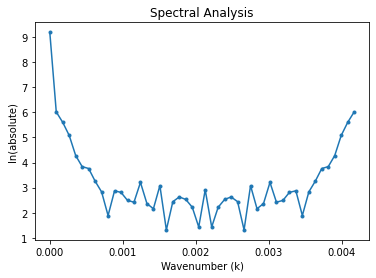

In [0]:
plt.plot(k, ln_abs, '.-')
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Cut-off Regional, Residual, Noise from Spectra

Text(0, 0.5, 'ln(absolute)')

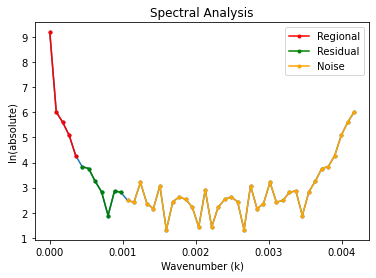

In [0]:
# guess the cutoff !!!
reg_cut = 5
res_cut = 12

k_reg_cut = k[:reg_cut]; ln_reg_cut = ln_abs[:reg_cut]
k_res_cut = k[reg_cut:res_cut]; ln_res_cut = ln_abs[reg_cut:res_cut]
k_noise_cut = k[res_cut:]; ln_noise_cut = ln_abs[res_cut:]

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')

plt.legend((p1[0], p2[0], p3[0]), ['Regional', 'Residual', 'Noise'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Determine window for Moving Average

#### Regression Function

In [0]:
def simple_linear_regression_traditional(x, y):
  import numpy as np
  x = np.array(x); y = np.array(y)
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  err_x = x - mean_x
  err_y = y - mean_y
  err_mult = err_x * err_y
  numerator = np.sum(err_mult)
  err_x_squared = err_x**2
  denominator = np.sum(err_x_squared)
  B1 = numerator / denominator
  B0 = mean_y - B1 * mean_x

  return(B0, B1) # B0 intercept, B1 gradient

#### Regression, calculate Cutt-off Frequency, calculate Window

In [0]:
#Regional Zone
B0, B1=simple_linear_regression_traditional(k_reg_cut, ln_reg_cut)

#Residual Zone
B2, B3=simple_linear_regression_traditional(k_res_cut, ln_res_cut)

# cut-off
cut_off = (B2-B0)/(B1-B3)

# window
windows = 2*np.pi/((fourier_data.Interval[3]-fourier_data.Interval[2])*cut_off)

print("Calculated window: ",windows, "\n")
print("Intercept for Regional Zone: ",B0)
print("Gradient for Regional Zone: ",B1)
print("Intercept for Residual Zone: ",B2)
print("Gradient for Residual Zone: ",B3)
print("Cut-off frequency: ",cut_off)

Calculated window:  11.912710200920335 

Intercept for Regional Zone:  8.186431735280394
Gradient for Regional Zone:  -12141.412774457052
Intercept for Residual Zone:  4.815578532770949
Gradient for Residual Zone:  -2507.225379002605
Cut-off frequency:  0.00034988453765180693


#### Windowing rule

Window must be an **odd number**. Rule and example:

* 1.25 rounded to 1. 1 is odd, so window = 1
* 1.75 rounded to 2. 2 is even, so window = 2 - 1 = 1
* 2.25 rounded to 2. 2 is even, so window = 2 + 1 = 3
* 2.75 rounded to 3. 3 is even, so window = 3

In [0]:
rounded = np.round(windows)

if rounded % 2 == 0:
  # even
  if (rounded - windows) > 0:
    window = rounded - 1
  if (rounded - windows) < 0:
    window = rounded + 1
else:
  # odd
  window = rounded

print("Selected odd window is:", window)

Selected odd window is: 11.0


#### Plot regression of spectrum

Text(0, 0.5, 'ln(absolute)')

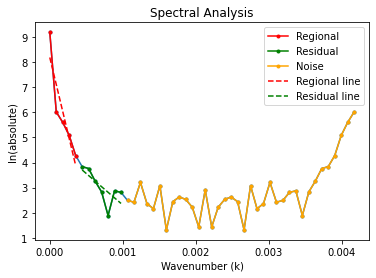

In [0]:
y_reg = B0 + B1 * k_reg_cut
y_res = B2 + B3 * k_res_cut

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')
p4 = plt.plot(k_reg_cut, y_reg, '--', color='red')
p5 = plt.plot(k_res_cut, y_res, '--', color='green')

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ['Regional', 'Residual', 'Noise', 'Regional line', 'Residual line'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Moving Average (Regional Separation)

In [0]:
regional = fourier_data.CBA.rolling(window=(int(window))).mean()

### Residual Separation

In [0]:
residual = fourier_data.CBA - regional

### Print dataframe

In [0]:
mva = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "Interval": data.Interval, "CBA": data.CBA, "Regional": regional, "Residual": residual})
mva.head(20)

,UTM_X,UTM_Y,Interval,CBA,Regional,Residual
0,288964.640341,4.243502e+06,0.000000,-210.684510,NaN,NaN
1,290472.095982,4.243502e+06,1507.455641,-208.941836,NaN,NaN
2,291979.551622,4.243502e+06,3014.911282,-202.793251,NaN,NaN
3,293487.007263,4.243502e+06,4522.366922,-198.273014,NaN,NaN
4,294994.462904,4.243502e+06,6029.822563,-196.881126,NaN,NaN
5,296501.918545,4.243502e+06,7537.278204,-196.246887,NaN,NaN
6,298009.374186,4.243502e+06,9044.733845,-195.270077,NaN,NaN
7,299516.829827,4.243502e+06,10552.189486,-193.743529,NaN,NaN
8,301024.285467,4.243502e+06,12059.645127,-193.627887,NaN,NaN
9,302531.741108,4.243502e+06,13567.100767,-193.808854,NaN,NaN


### Plot CBA, Regional, Residual Slice

Text(0, 0.5, 'Regional anomaly (mgal)')

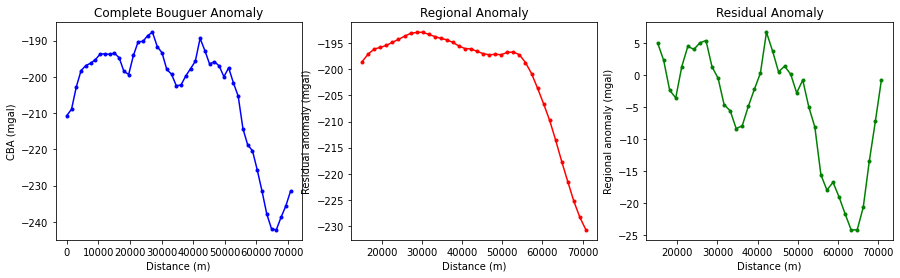

In [0]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(mva.Interval, mva.CBA, '.-', color='blue')
plt.title('Complete Bouguer Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('CBA (mgal)')
plt.subplot(1,3,2)
plt.plot(mva.Interval, mva.Regional, '.-', color='red')
plt.title('Regional Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Residual anomaly (mgal)')
plt.subplot(1,3,3)
plt.plot(mva.Interval, mva.Residual, '.-', color='green')
plt.title('Residual Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Regional anomaly (mgal)')

### Save data into CSV

In [0]:
mva.to_csv('/content/fft_E-W_1.csv') 

## East-West Slice 2

In [0]:
# E-W slice
x_slice = xi[25]
print('Coordinate slice in X direction:', x_slice)

y_slice = yi[25]
print('Coordinate slice in Y direction:', y_slice)

g_slice = zi[25]
print('CBA on slice:', g_slice)

Coordinate slice in X direction: [287457.1847     288964.64034082 290472.09598163 291979.55162245
 293487.00726327 294994.46290408 296501.9185449  298009.37418571
 299516.82982653 301024.28546735 302531.74110816 304039.19674898
 305546.6523898  307054.10803061 308561.56367143 310069.01931224
 311576.47495306 313083.93059388 314591.38623469 316098.84187551
 317606.29751633 319113.75315714 320621.20879796 322128.66443878
 323636.12007959 325143.57572041 326651.03136122 328158.48700204
 329665.94264286 331173.39828367 332680.85392449 334188.30956531
 335695.76520612 337203.22084694 338710.67648776 340218.13212857
 341725.58776939 343233.0434102  344740.49905102 346247.95469184
 347755.41033265 349262.86597347 350770.32161429 352277.7772551
 353785.23289592 355292.68853673 356800.14417755 358307.59981837
 359815.05545918 361322.5111    ]
Coordinate slice in Y direction: [4261705.01222449 4261705.01222449 4261705.01222449 4261705.01222449
 4261705.01222449 4261705.01222449 4261705.01222449 

Visualize the slice

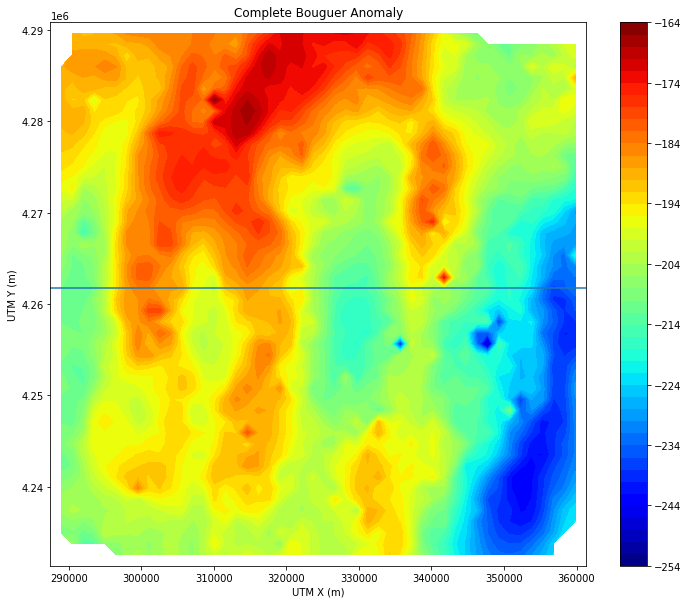

In [0]:
import scipy
from scipy.interpolate import griddata

xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)
# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi),method='cubic')

fig, ax = plt.subplots(figsize=(12,10))
# plot CBA contours
im = ax.contourf(xi,yi,zi,levels=50, cmap="jet")
ax.set_title('Complete Bouguer Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
fig.colorbar(im)

im = plt.plot(x_slice, y_slice)

### Data preparation for FFT

Create dataframe

In [0]:
data = pd.DataFrame({"UTM_X": x_slice, "UTM_Y": y_slice, "CBA": g_slice})
data.head(10)

,UTM_X,UTM_Y,CBA
0,287457.184700,4.261705e+06,NaN
1,288964.640341,4.261705e+06,-209.973401
2,290472.095982,4.261705e+06,-211.127576
3,291979.551622,4.261705e+06,-211.359211
4,293487.007263,4.261705e+06,-210.023278
5,294994.462904,4.261705e+06,-202.325972
6,296501.918545,4.261705e+06,-194.140795
7,298009.374186,4.261705e+06,-187.117729
8,299516.829827,4.261705e+06,-184.471535
9,301024.285467,4.261705e+06,-184.619255


Remove NaN from dataframe

In [0]:
# look up the number of rows with NaN data
print("Original size of data:", len(data), "rows")
print("How many data with NaN values?")
print(data.isnull().sum())

# drop rows with missing values
data.dropna(inplace=True)
# re-index dataframe
data = data.reset_index(drop=True)
print("NaN has successfully been deleted")
data.head(10)

Original size of data: 50 rows
How many data with NaN values?
UTM_X    0
UTM_Y    0
CBA      2
dtype: int64
NaN has successfully been deleted


,UTM_X,UTM_Y,CBA
0,288964.640341,4.261705e+06,-209.973401
1,290472.095982,4.261705e+06,-211.127576
2,291979.551622,4.261705e+06,-211.359211
3,293487.007263,4.261705e+06,-210.023278
4,294994.462904,4.261705e+06,-202.325972
5,296501.918545,4.261705e+06,-194.140795
6,298009.374186,4.261705e+06,-187.117729
7,299516.829827,4.261705e+06,-184.471535
8,301024.285467,4.261705e+06,-184.619255
9,302531.741108,4.261705e+06,-188.369917


Calculate interval on slice

In [0]:
# calculate distance on slice from the first point on slice
dist_x = np.array([j-i for i, j in zip(data.UTM_X[:-1], data.UTM_X[1:])])
dist_y = np.array([j-i for i, j in zip(data.UTM_Y[:-1], data.UTM_Y[1:])])
dist = np.sqrt((dist_x**2) + (dist_y**2))
dist = np.cumsum(dist)
dist = np.append(0, dist)

Put interval into dataframe

In [0]:
data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": dist})
data.head(10)

,UTM_X,UTM_Y,CBA,Interval
0,288964.640341,4.261705e+06,-209.973401,0.000000
1,290472.095982,4.261705e+06,-211.127576,1507.455641
2,291979.551622,4.261705e+06,-211.359211,3014.911282
3,293487.007263,4.261705e+06,-210.023278,4522.366922
4,294994.462904,4.261705e+06,-202.325972,6029.822563
5,296501.918545,4.261705e+06,-194.140795,7537.278204
6,298009.374186,4.261705e+06,-187.117729,9044.733845
7,299516.829827,4.261705e+06,-184.471535,10552.189486
8,301024.285467,4.261705e+06,-184.619255,12059.645127
9,302531.741108,4.261705e+06,-188.369917,13567.100767


### Fourier Transform

In [0]:
def dft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

fourier = np.fft.fft(data.CBA)
print(len(fourier))

48


In [0]:
imaginary = fourier.imag
real = fourier.real
absolute = np.sqrt((imaginary**2) + (real**2))
ln_abs = np.log(absolute)

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute
0,288964.640341,4.261705e+06,-209.973401,0.000000,-9836.710349+0.000000j,-9836.710349,0.000000,9836.710349,9.193877
1,290472.095982,4.261705e+06,-211.127576,1507.455641,-158.161350-292.441830j,-158.161350,-292.441830,332.471407,5.806554
2,291979.551622,4.261705e+06,-211.359211,3014.911282,-195.540727-106.362532j,-195.540727,-106.362532,222.596415,5.405360
3,293487.007263,4.261705e+06,-210.023278,4522.366922,-18.723584-167.054777j,-18.723584,-167.054777,168.100776,5.124564
4,294994.462904,4.261705e+06,-202.325972,6029.822563,-78.753878+43.367339j,-78.753878,43.367339,89.904946,4.498753
5,296501.918545,4.261705e+06,-194.140795,7537.278204,21.215810-21.215768j,21.215810,-21.215768,30.003656,3.401319
6,298009.374186,4.261705e+06,-187.117729,9044.733845,56.838667-35.216474j,56.838667,-35.216474,66.864296,4.202665
7,299516.829827,4.261705e+06,-184.471535,10552.189486,15.984289-24.078322j,15.984289,-24.078322,28.900919,3.363873
8,301024.285467,4.261705e+06,-184.619255,12059.645127,41.765348-8.904990j,41.765348,-8.904990,42.704135,3.754296
9,302531.741108,4.261705e+06,-188.369917,13567.100767,54.726037-21.268350j,54.726037,-21.268350,58.713557,4.072671


Compute sampling frequency

In [0]:
# compute freq sampling
interval_last = fourier_data.Interval.iloc[-1]
minus = interval_last - fourier_data.Interval.iloc[0]

f_s = 0 # initial freq sampling
f_sample = []
for i in range(0,len(fourier_data.CBA)-1):
  f_s = f_s + (1 / minus)
  f_sample.append(float(f_s))
f_sample = np.append(0, f_sample)

# put into dataframe
fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample
0,288964.640341,4.261705e+06,-209.973401,0.000000,-9836.710349+0.000000j,-9836.710349,0.000000,9836.710349,9.193877,0.000000
1,290472.095982,4.261705e+06,-211.127576,1507.455641,-158.161350-292.441830j,-158.161350,-292.441830,332.471407,5.806554,0.000014
2,291979.551622,4.261705e+06,-211.359211,3014.911282,-195.540727-106.362532j,-195.540727,-106.362532,222.596415,5.405360,0.000028
3,293487.007263,4.261705e+06,-210.023278,4522.366922,-18.723584-167.054777j,-18.723584,-167.054777,168.100776,5.124564,0.000042
4,294994.462904,4.261705e+06,-202.325972,6029.822563,-78.753878+43.367339j,-78.753878,43.367339,89.904946,4.498753,0.000056
5,296501.918545,4.261705e+06,-194.140795,7537.278204,21.215810-21.215768j,21.215810,-21.215768,30.003656,3.401319,0.000071
6,298009.374186,4.261705e+06,-187.117729,9044.733845,56.838667-35.216474j,56.838667,-35.216474,66.864296,4.202665,0.000085
7,299516.829827,4.261705e+06,-184.471535,10552.189486,15.984289-24.078322j,15.984289,-24.078322,28.900919,3.363873,0.000099
8,301024.285467,4.261705e+06,-184.619255,12059.645127,41.765348-8.904990j,41.765348,-8.904990,42.704135,3.754296,0.000113
9,302531.741108,4.261705e+06,-188.369917,13567.100767,54.726037-21.268350j,54.726037,-21.268350,58.713557,4.072671,0.000127


Wavenumber

In [0]:
k = 2 * np.pi * f_sample

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample, "Wavenumber": k})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample,Wavenumber
0,288964.640341,4.261705e+06,-209.973401,0.000000,-9836.710349+0.000000j,-9836.710349,0.000000,9836.710349,9.193877,0.000000,0.000000
1,290472.095982,4.261705e+06,-211.127576,1507.455641,-158.161350-292.441830j,-158.161350,-292.441830,332.471407,5.806554,0.000014,0.000089
2,291979.551622,4.261705e+06,-211.359211,3014.911282,-195.540727-106.362532j,-195.540727,-106.362532,222.596415,5.405360,0.000028,0.000177
3,293487.007263,4.261705e+06,-210.023278,4522.366922,-18.723584-167.054777j,-18.723584,-167.054777,168.100776,5.124564,0.000042,0.000266
4,294994.462904,4.261705e+06,-202.325972,6029.822563,-78.753878+43.367339j,-78.753878,43.367339,89.904946,4.498753,0.000056,0.000355
5,296501.918545,4.261705e+06,-194.140795,7537.278204,21.215810-21.215768j,21.215810,-21.215768,30.003656,3.401319,0.000071,0.000443
6,298009.374186,4.261705e+06,-187.117729,9044.733845,56.838667-35.216474j,56.838667,-35.216474,66.864296,4.202665,0.000085,0.000532
7,299516.829827,4.261705e+06,-184.471535,10552.189486,15.984289-24.078322j,15.984289,-24.078322,28.900919,3.363873,0.000099,0.000621
8,301024.285467,4.261705e+06,-184.619255,12059.645127,41.765348-8.904990j,41.765348,-8.904990,42.704135,3.754296,0.000113,0.000709
9,302531.741108,4.261705e+06,-188.369917,13567.100767,54.726037-21.268350j,54.726037,-21.268350,58.713557,4.072671,0.000127,0.000798


Plot Spectrum

Text(0, 0.5, 'ln(absolute)')

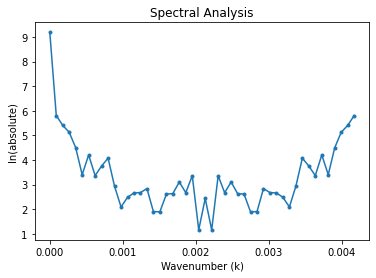

In [0]:
plt.plot(k, ln_abs, '.-')
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Cut-off Regional, Residual, Noise from Spectra

Text(0, 0.5, 'ln(absolute)')

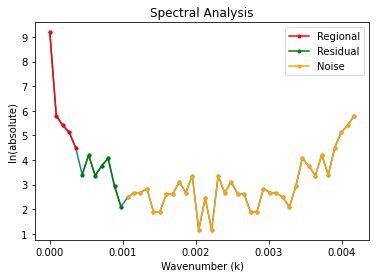

In [0]:
# guess the cutoff !!!
reg_cut = 5
res_cut = 12

k_reg_cut = k[:reg_cut]; ln_reg_cut = ln_abs[:reg_cut]
k_res_cut = k[reg_cut:res_cut]; ln_res_cut = ln_abs[reg_cut:res_cut]
k_noise_cut = k[res_cut:]; ln_noise_cut = ln_abs[res_cut:]

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')

plt.legend((p1[0], p2[0], p3[0]), ['Regional', 'Residual', 'Noise'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Determine window for Moving Average

#### Regression Function

In [0]:
def simple_linear_regression_traditional(x, y):
  import numpy as np
  x = np.array(x); y = np.array(y)
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  err_x = x - mean_x
  err_y = y - mean_y
  err_mult = err_x * err_y
  numerator = np.sum(err_mult)
  err_x_squared = err_x**2
  denominator = np.sum(err_x_squared)
  B1 = numerator / denominator
  B0 = mean_y - B1 * mean_x

  return(B0, B1) # B0 intercept, B1 gradient

#### Regression, calculate Cutt-off Frequency, calculate Window

In [0]:
#Regional Zone
B0, B1=simple_linear_regression_traditional(k_reg_cut, ln_reg_cut)

#Residual Zone
B2, B3=simple_linear_regression_traditional(k_res_cut, ln_res_cut)

# cut-off
cut_off = (B2-B0)/(B1-B3)

# window
windows = 2*np.pi/((fourier_data.Interval[3]-fourier_data.Interval[2])*cut_off)

print("Calculated window: ",windows, "\n")
print("Intercept for Regional Zone: ",B0)
print("Gradient for Regional Zone: ",B1)
print("Intercept for Residual Zone: ",B2)
print("Gradient for Residual Zone: ",B3)
print("Cut-off frequency: ",cut_off)

Calculated window:  12.678199164131223 

Intercept for Regional Zone:  8.020268991675945
Gradient for Regional Zone:  -11357.650216982422
Intercept for Residual Zone:  5.049628318635339
Gradient for Residual Zone:  -2321.7304557893963
Cut-off frequency:  0.00032875908059727926


#### Windowing rule

Window must be an **odd number**. Rule and example:

* 1.25 rounded to 1. 1 is odd, so window = 1
* 1.75 rounded to 2. 2 is even, so window = 2 - 1 = 1
* 2.25 rounded to 2. 2 is even, so window = 2 + 1 = 3
* 2.75 rounded to 3. 3 is even, so window = 3

In [0]:
rounded = np.round(windows)

if rounded % 2 == 0:
  # even
  if (rounded - windows) > 0:
    window = rounded - 1
  if (rounded - windows) < 0:
    window = rounded + 1
else:
  # odd
  window = rounded

print("Selected odd window is:", window)

Selected odd window is: 13.0


#### Plot regression of spectrum

Text(0, 0.5, 'ln(absolute)')

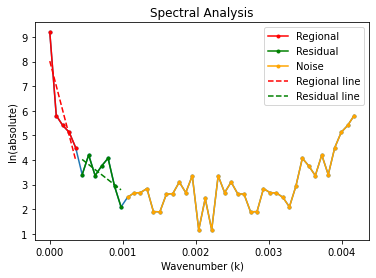

In [0]:
y_reg = B0 + B1 * k_reg_cut
y_res = B2 + B3 * k_res_cut

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')
p4 = plt.plot(k_reg_cut, y_reg, '--', color='red')
p5 = plt.plot(k_res_cut, y_res, '--', color='green')

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ['Regional', 'Residual', 'Noise', 'Regional line', 'Residual line'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Moving Average (Regional Separation)

In [0]:
regional = fourier_data.CBA.rolling(window=(int(window))).mean()

### Residual Separation

In [0]:
residual = fourier_data.CBA - regional

### Print dataframe

In [0]:
mva = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "Interval": data.Interval, "CBA": data.CBA, "Regional": regional, "Residual": residual})
mva.head(20)

,UTM_X,UTM_Y,Interval,CBA,Regional,Residual
0,288964.640341,4.261705e+06,0.000000,-209.973401,NaN,NaN
1,290472.095982,4.261705e+06,1507.455641,-211.127576,NaN,NaN
2,291979.551622,4.261705e+06,3014.911282,-211.359211,NaN,NaN
3,293487.007263,4.261705e+06,4522.366922,-210.023278,NaN,NaN
4,294994.462904,4.261705e+06,6029.822563,-202.325972,NaN,NaN
5,296501.918545,4.261705e+06,7537.278204,-194.140795,NaN,NaN
6,298009.374186,4.261705e+06,9044.733845,-187.117729,NaN,NaN
7,299516.829827,4.261705e+06,10552.189486,-184.471535,NaN,NaN
8,301024.285467,4.261705e+06,12059.645127,-184.619255,NaN,NaN
9,302531.741108,4.261705e+06,13567.100767,-188.369917,NaN,NaN


### Plot CBA, Regional, Residual Slice

Text(0, 0.5, 'Regional anomaly (mgal)')

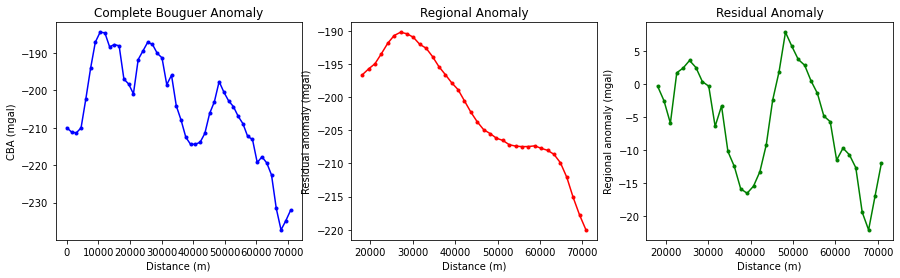

In [0]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(mva.Interval, mva.CBA, '.-', color='blue')
plt.title('Complete Bouguer Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('CBA (mgal)')
plt.subplot(1,3,2)
plt.plot(mva.Interval, mva.Regional, '.-', color='red')
plt.title('Regional Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Residual anomaly (mgal)')
plt.subplot(1,3,3)
plt.plot(mva.Interval, mva.Residual, '.-', color='green')
plt.title('Residual Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Regional anomaly (mgal)')

### Save data into CSV

In [0]:
mva.to_csv('/content/fft_E-W_2.csv') 

## East-West Slice 3

In [0]:
# E-W slice
x_slice = xi[40]
print('Coordinate slice in X direction:', x_slice)

y_slice = yi[40]
print('Coordinate slice in Y direction:', y_slice)

g_slice = zi[40]
print('CBA on slice:', g_slice)

Coordinate slice in X direction: [287457.1847     288964.64034082 290472.09598163 291979.55162245
 293487.00726327 294994.46290408 296501.9185449  298009.37418571
 299516.82982653 301024.28546735 302531.74110816 304039.19674898
 305546.6523898  307054.10803061 308561.56367143 310069.01931224
 311576.47495306 313083.93059388 314591.38623469 316098.84187551
 317606.29751633 319113.75315714 320621.20879796 322128.66443878
 323636.12007959 325143.57572041 326651.03136122 328158.48700204
 329665.94264286 331173.39828367 332680.85392449 334188.30956531
 335695.76520612 337203.22084694 338710.67648776 340218.13212857
 341725.58776939 343233.0434102  344740.49905102 346247.95469184
 347755.41033265 349262.86597347 350770.32161429 352277.7772551
 353785.23289592 355292.68853673 356800.14417755 358307.59981837
 359815.05545918 361322.5111    ]
Coordinate slice in Y direction: [4279908.26895918 4279908.26895918 4279908.26895918 4279908.26895918
 4279908.26895918 4279908.26895918 4279908.26895918 

Visualize the slice

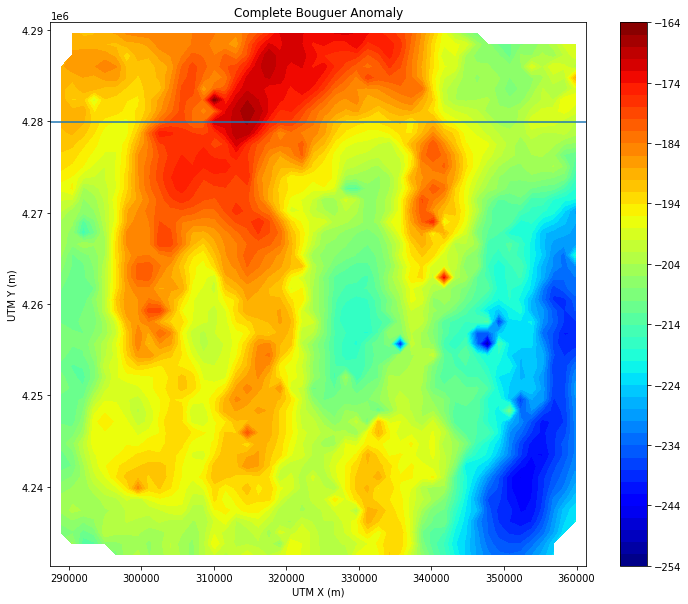

In [0]:
import scipy
from scipy.interpolate import griddata

xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)
# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi),method='cubic')

fig, ax = plt.subplots(figsize=(12,10))
# plot CBA contours
im = ax.contourf(xi,yi,zi,levels=50, cmap="jet")
ax.set_title('Complete Bouguer Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
fig.colorbar(im)

im = plt.plot(x_slice, y_slice)

### Data preparation for FFT

Create dataframe

In [0]:
data = pd.DataFrame({"UTM_X": x_slice, "UTM_Y": y_slice, "CBA": g_slice})
data.head(10)

,UTM_X,UTM_Y,CBA
0,287457.184700,4.279908e+06,NaN
1,288964.640341,4.279908e+06,-189.638478
2,290472.095982,4.279908e+06,-188.956623
3,291979.551622,4.279908e+06,-189.830115
4,293487.007263,4.279908e+06,-192.904334
5,294994.462904,4.279908e+06,-195.157881
6,296501.918545,4.279908e+06,-196.249216
7,298009.374186,4.279908e+06,-196.592312
8,299516.829827,4.279908e+06,-193.503219
9,301024.285467,4.279908e+06,-188.310866


Remove NaN from dataframe

In [0]:
# look up the number of rows with NaN data
print("Original size of data:", len(data), "rows")
print("How many data with NaN values?")
print(data.isnull().sum())

# drop rows with missing values
data.dropna(inplace=True)
# re-index dataframe
data = data.reset_index(drop=True)
print("NaN has successfully been deleted")
data.head(10)

Original size of data: 50 rows
How many data with NaN values?
UTM_X    0
UTM_Y    0
CBA      2
dtype: int64
NaN has successfully been deleted


,UTM_X,UTM_Y,CBA
0,288964.640341,4.279908e+06,-189.638478
1,290472.095982,4.279908e+06,-188.956623
2,291979.551622,4.279908e+06,-189.830115
3,293487.007263,4.279908e+06,-192.904334
4,294994.462904,4.279908e+06,-195.157881
5,296501.918545,4.279908e+06,-196.249216
6,298009.374186,4.279908e+06,-196.592312
7,299516.829827,4.279908e+06,-193.503219
8,301024.285467,4.279908e+06,-188.310866
9,302531.741108,4.279908e+06,-182.934747


Calculate interval on slice

In [0]:
# calculate distance on slice from the first point on slice
dist_x = np.array([j-i for i, j in zip(data.UTM_X[:-1], data.UTM_X[1:])])
dist_y = np.array([j-i for i, j in zip(data.UTM_Y[:-1], data.UTM_Y[1:])])
dist = np.sqrt((dist_x**2) + (dist_y**2))
dist = np.cumsum(dist)
dist = np.append(0, dist)

Put interval into dataframe

In [0]:
data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": dist})
data.head(10)

,UTM_X,UTM_Y,CBA,Interval
0,288964.640341,4.279908e+06,-189.638478,0.000000
1,290472.095982,4.279908e+06,-188.956623,1507.455641
2,291979.551622,4.279908e+06,-189.830115,3014.911282
3,293487.007263,4.279908e+06,-192.904334,4522.366922
4,294994.462904,4.279908e+06,-195.157881,6029.822563
5,296501.918545,4.279908e+06,-196.249216,7537.278204
6,298009.374186,4.279908e+06,-196.592312,9044.733845
7,299516.829827,4.279908e+06,-193.503219,10552.189486
8,301024.285467,4.279908e+06,-188.310866,12059.645127
9,302531.741108,4.279908e+06,-182.934747,13567.100767


### Fourier Transform

In [0]:
def dft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

fourier = np.fft.fft(data.CBA)
print(len(fourier))

48


In [0]:
imaginary = fourier.imag
real = fourier.real
absolute = np.sqrt((imaginary**2) + (real**2))
ln_abs = np.log(absolute)

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute
0,288964.640341,4.279908e+06,-189.638478,0.000000,-9100.689422+0.000000j,-9100.689422,0.000000,9100.689422,9.116105
1,290472.095982,4.279908e+06,-188.956623,1507.455641,-170.902322-244.739961j,-170.902322,-244.739961,298.505028,5.698787
2,291979.551622,4.279908e+06,-189.830115,3014.911282,-46.518664+64.607254j,-46.518664,64.607254,79.612081,4.377166
3,293487.007263,4.279908e+06,-192.904334,4522.366922,97.978572-28.605932j,97.978572,-28.605932,102.069094,4.625650
4,294994.462904,4.279908e+06,-195.157881,6029.822563,18.635656+14.258953j,18.635656,14.258953,23.464983,3.155509
5,296501.918545,4.279908e+06,-196.249216,7537.278204,7.403537-2.768344j,7.403537,-2.768344,7.904181,2.067392
6,298009.374186,4.279908e+06,-196.592312,9044.733845,20.642942-39.951435j,20.642942,-39.951435,44.969414,3.805983
7,299516.829827,4.279908e+06,-193.503219,10552.189486,-20.010088-48.129146j,-20.010088,-48.129146,52.123107,3.953608
8,301024.285467,4.279908e+06,-188.310866,12059.645127,-15.287018-2.559395j,-15.287018,-2.559395,15.499788,2.740826
9,302531.741108,4.279908e+06,-182.934747,13567.100767,10.306809-17.300182j,10.306809,-17.300182,20.137691,3.002593


Compute sampling frequency

In [0]:
# compute freq sampling
interval_last = fourier_data.Interval.iloc[-1]
minus = interval_last - fourier_data.Interval.iloc[0]

f_s = 0 # initial freq sampling
f_sample = []
for i in range(0,len(fourier_data.CBA)-1):
  f_s = f_s + (1 / minus)
  f_sample.append(float(f_s))
f_sample = np.append(0, f_sample)

# put into dataframe
fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample
0,288964.640341,4.279908e+06,-189.638478,0.000000,-9100.689422+0.000000j,-9100.689422,0.000000,9100.689422,9.116105,0.000000
1,290472.095982,4.279908e+06,-188.956623,1507.455641,-170.902322-244.739961j,-170.902322,-244.739961,298.505028,5.698787,0.000014
2,291979.551622,4.279908e+06,-189.830115,3014.911282,-46.518664+64.607254j,-46.518664,64.607254,79.612081,4.377166,0.000028
3,293487.007263,4.279908e+06,-192.904334,4522.366922,97.978572-28.605932j,97.978572,-28.605932,102.069094,4.625650,0.000042
4,294994.462904,4.279908e+06,-195.157881,6029.822563,18.635656+14.258953j,18.635656,14.258953,23.464983,3.155509,0.000056
5,296501.918545,4.279908e+06,-196.249216,7537.278204,7.403537-2.768344j,7.403537,-2.768344,7.904181,2.067392,0.000071
6,298009.374186,4.279908e+06,-196.592312,9044.733845,20.642942-39.951435j,20.642942,-39.951435,44.969414,3.805983,0.000085
7,299516.829827,4.279908e+06,-193.503219,10552.189486,-20.010088-48.129146j,-20.010088,-48.129146,52.123107,3.953608,0.000099
8,301024.285467,4.279908e+06,-188.310866,12059.645127,-15.287018-2.559395j,-15.287018,-2.559395,15.499788,2.740826,0.000113
9,302531.741108,4.279908e+06,-182.934747,13567.100767,10.306809-17.300182j,10.306809,-17.300182,20.137691,3.002593,0.000127


Wavenumber

In [0]:
k = 2 * np.pi * f_sample

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample, "Wavenumber": k})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample,Wavenumber
0,288964.640341,4.279908e+06,-189.638478,0.000000,-9100.689422+0.000000j,-9100.689422,0.000000,9100.689422,9.116105,0.000000,0.000000
1,290472.095982,4.279908e+06,-188.956623,1507.455641,-170.902322-244.739961j,-170.902322,-244.739961,298.505028,5.698787,0.000014,0.000089
2,291979.551622,4.279908e+06,-189.830115,3014.911282,-46.518664+64.607254j,-46.518664,64.607254,79.612081,4.377166,0.000028,0.000177
3,293487.007263,4.279908e+06,-192.904334,4522.366922,97.978572-28.605932j,97.978572,-28.605932,102.069094,4.625650,0.000042,0.000266
4,294994.462904,4.279908e+06,-195.157881,6029.822563,18.635656+14.258953j,18.635656,14.258953,23.464983,3.155509,0.000056,0.000355
5,296501.918545,4.279908e+06,-196.249216,7537.278204,7.403537-2.768344j,7.403537,-2.768344,7.904181,2.067392,0.000071,0.000443
6,298009.374186,4.279908e+06,-196.592312,9044.733845,20.642942-39.951435j,20.642942,-39.951435,44.969414,3.805983,0.000085,0.000532
7,299516.829827,4.279908e+06,-193.503219,10552.189486,-20.010088-48.129146j,-20.010088,-48.129146,52.123107,3.953608,0.000099,0.000621
8,301024.285467,4.279908e+06,-188.310866,12059.645127,-15.287018-2.559395j,-15.287018,-2.559395,15.499788,2.740826,0.000113,0.000709
9,302531.741108,4.279908e+06,-182.934747,13567.100767,10.306809-17.300182j,10.306809,-17.300182,20.137691,3.002593,0.000127,0.000798


Plot Spectrum

Text(0, 0.5, 'ln(absolute)')

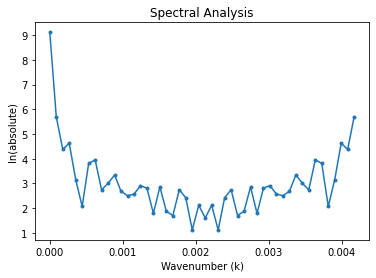

In [0]:
plt.plot(k, ln_abs, '.-')
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Cut-off Regional, Residual, Noise from Spectra

Text(0, 0.5, 'ln(absolute)')

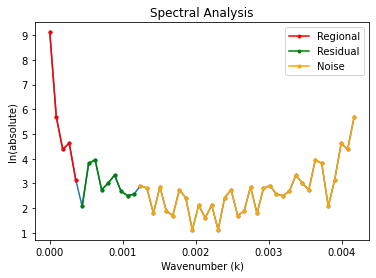

In [0]:
# guess the cutoff !!!
reg_cut = 5
res_cut = 14

k_reg_cut = k[:reg_cut]; ln_reg_cut = ln_abs[:reg_cut]
k_res_cut = k[reg_cut:res_cut]; ln_res_cut = ln_abs[reg_cut:res_cut]
k_noise_cut = k[res_cut:]; ln_noise_cut = ln_abs[res_cut:]

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')

plt.legend((p1[0], p2[0], p3[0]), ['Regional', 'Residual', 'Noise'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Determine window for Moving Average

#### Regression Function

In [0]:
def simple_linear_regression_traditional(x, y):
  import numpy as np
  x = np.array(x); y = np.array(y)
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  err_x = x - mean_x
  err_y = y - mean_y
  err_mult = err_x * err_y
  numerator = np.sum(err_mult)
  err_x_squared = err_x**2
  denominator = np.sum(err_x_squared)
  B1 = numerator / denominator
  B0 = mean_y - B1 * mean_x

  return(B0, B1) # B0 intercept, B1 gradient

#### Regression, calculate Cutt-off Frequency, calculate Window

In [0]:
#Regional Zone
B0, B1=simple_linear_regression_traditional(k_reg_cut, ln_reg_cut)

#Residual Zone
B2, B3=simple_linear_regression_traditional(k_res_cut, ln_res_cut)

# cut-off
cut_off = (B2-B0)/(B1-B3)

# window
windows = 2*np.pi/((fourier_data.Interval[3]-fourier_data.Interval[2])*cut_off)

print("Calculated window: ",windows, "\n")
print("Intercept for Regional Zone: ",B0)
print("Gradient for Regional Zone: ",B1)
print("Intercept for Residual Zone: ",B2)
print("Gradient for Residual Zone: ",B3)
print("Cut-off frequency: ",cut_off)

Calculated window:  13.040299612959743 

Intercept for Regional Zone:  7.993509306273456
Gradient for Regional Zone:  -14652.657477104003
Intercept for Residual Zone:  3.542663412764833
Gradient for Residual Zone:  -727.6704199143179
Cut-off frequency:  0.0003196301637645389


#### Windowing rule

Window must be an **odd number**. Rule and example:

* 1.25 rounded to 1. 1 is odd, so window = 1
* 1.75 rounded to 2. 2 is even, so window = 2 - 1 = 1
* 2.25 rounded to 2. 2 is even, so window = 2 + 1 = 3
* 2.75 rounded to 3. 3 is even, so window = 3

In [0]:
rounded = np.round(windows)

if rounded % 2 == 0:
  # even
  if (rounded - windows) > 0:
    window = rounded - 1
  if (rounded - windows) < 0:
    window = rounded + 1
else:
  # odd
  window = rounded

print("Selected odd window is:", window)

Selected odd window is: 13.0


#### Plot regression of spectrum

Text(0, 0.5, 'ln(absolute)')

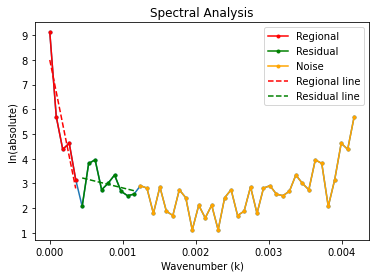

In [0]:
y_reg = B0 + B1 * k_reg_cut
y_res = B2 + B3 * k_res_cut

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')
p4 = plt.plot(k_reg_cut, y_reg, '--', color='red')
p5 = plt.plot(k_res_cut, y_res, '--', color='green')

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ['Regional', 'Residual', 'Noise', 'Regional line', 'Residual line'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Moving Average (Regional Separation)

In [0]:
regional = fourier_data.CBA.rolling(window=(int(window))).mean()

### Residual Separation

In [0]:
residual = fourier_data.CBA - regional

### Print dataframe

In [0]:
mva = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "Interval": data.Interval, "CBA": data.CBA, "Regional": regional, "Residual": residual})
mva.head(20)

,UTM_X,UTM_Y,Interval,CBA,Regional,Residual
0,288964.640341,4.279908e+06,0.000000,-189.638478,NaN,NaN
1,290472.095982,4.279908e+06,1507.455641,-188.956623,NaN,NaN
2,291979.551622,4.279908e+06,3014.911282,-189.830115,NaN,NaN
3,293487.007263,4.279908e+06,4522.366922,-192.904334,NaN,NaN
4,294994.462904,4.279908e+06,6029.822563,-195.157881,NaN,NaN
5,296501.918545,4.279908e+06,7537.278204,-196.249216,NaN,NaN
6,298009.374186,4.279908e+06,9044.733845,-196.592312,NaN,NaN
7,299516.829827,4.279908e+06,10552.189486,-193.503219,NaN,NaN
8,301024.285467,4.279908e+06,12059.645127,-188.310866,NaN,NaN
9,302531.741108,4.279908e+06,13567.100767,-182.934747,NaN,NaN


### Plot CBA, Regional, Residual Slice

Text(0, 0.5, 'Regional anomaly (mgal)')

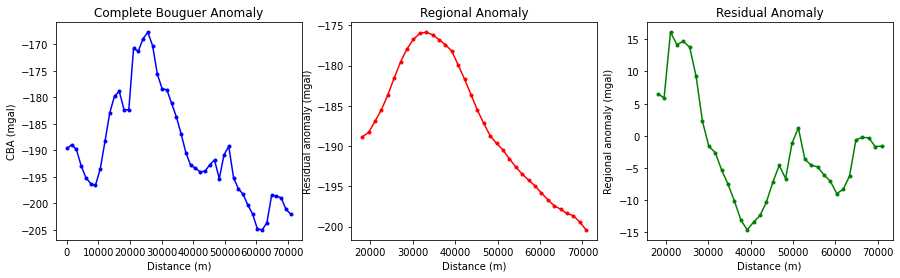

In [0]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(mva.Interval, mva.CBA, '.-', color='blue')
plt.title('Complete Bouguer Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('CBA (mgal)')
plt.subplot(1,3,2)
plt.plot(mva.Interval, mva.Regional, '.-', color='red')
plt.title('Regional Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Residual anomaly (mgal)')
plt.subplot(1,3,3)
plt.plot(mva.Interval, mva.Residual, '.-', color='green')
plt.title('Residual Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Regional anomaly (mgal)')

### Save data into CSV

In [0]:
mva.to_csv('/content/fft_E-W_3.csv') 

## North-South Slice 1

<div>
<img src="https://user-images.githubusercontent.com/51282928/77561902-ec5e5400-6ef1-11ea-988f-11800cdadc68.jpeg" width="350"/>
</div>

In [0]:
# N-S slice

loc = 10

x_slice = []
for k in range(len(xi)):
  xslice = xi[k][loc]
  x_slice.append(float(xslice))
x_slice = np.array(x_slice)
print('Coordinate slice in X direction:', x_slice, '\n')

y_slice = []
for k in range(len(xi)):
  yslice = yi[k][k]
  y_slice.append(float(yslice))
y_slice = np.array(y_slice)
print('Coordinate slice in Y direction:', y_slice, '\n')

g_slice = []
for k in range(len(xi)):
  gslice = zi[k][loc]
  g_slice.append(float(gslice))
g_slice = np.array(g_slice)
print('CBA on slice:', g_slice)

Coordinate slice in X direction: [302531.74110816 302531.74110816 302531.74110816 302531.74110816
 302531.74110816 302531.74110816 302531.74110816 302531.74110816
 302531.74110816 302531.74110816 302531.74110816 302531.74110816
 302531.74110816 302531.74110816 302531.74110816 302531.74110816
 302531.74110816 302531.74110816 302531.74110816 302531.74110816
 302531.74110816 302531.74110816 302531.74110816 302531.74110816
 302531.74110816 302531.74110816 302531.74110816 302531.74110816
 302531.74110816 302531.74110816 302531.74110816 302531.74110816
 302531.74110816 302531.74110816 302531.74110816 302531.74110816
 302531.74110816 302531.74110816 302531.74110816 302531.74110816
 302531.74110816 302531.74110816 302531.74110816 302531.74110816
 302531.74110816 302531.74110816 302531.74110816 302531.74110816
 302531.74110816 302531.74110816] 

Coordinate slice in Y direction: [4231366.251      4232579.80144898 4233793.35189796 4235006.90234694
 4236220.45279592 4237434.0032449  4238647.553693

Visualize the slice

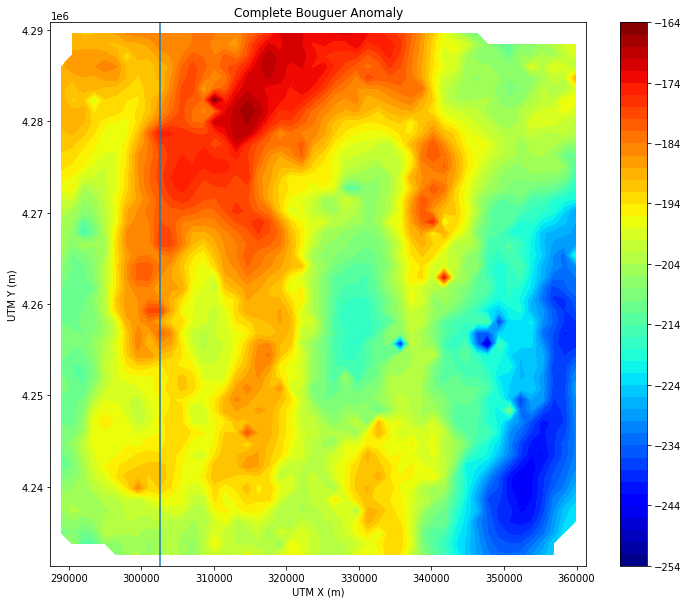

In [0]:
import scipy
from scipy.interpolate import griddata

xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)
# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi),method='cubic')

fig, ax = plt.subplots(figsize=(12,10))
# plot CBA contours
im = ax.contourf(xi,yi,zi,levels=50, cmap="jet")
ax.set_title('Complete Bouguer Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
fig.colorbar(im)

im = plt.plot(x_slice, y_slice)

### Data preparation for FFT

Create dataframe

In [0]:
data = pd.DataFrame({"UTM_X": x_slice, "UTM_Y": y_slice, "CBA": g_slice})
data.head(10)

,UTM_X,UTM_Y,CBA
0,302531.741108,4.231366e+06,NaN
1,302531.741108,4.232580e+06,-205.232592
2,302531.741108,4.233793e+06,-204.659708
3,302531.741108,4.235007e+06,-204.668045
4,302531.741108,4.236220e+06,-201.718622
5,302531.741108,4.237434e+06,-200.246995
6,302531.741108,4.238648e+06,-196.424674
7,302531.741108,4.239861e+06,-191.891713
8,302531.741108,4.241075e+06,-190.022098
9,302531.741108,4.242288e+06,-191.161895


Remove NaN from dataframe

In [0]:
# look up the number of rows with NaN data
print("Original size of data:", len(data), "rows")
print("How many data with NaN values?")
print(data.isnull().sum())

# drop rows with missing values
data.dropna(inplace=True)
# re-index dataframe
data = data.reset_index(drop=True)
print("NaN has successfully been deleted")
data.head(10)

Original size of data: 50 rows
How many data with NaN values?
UTM_X    0
UTM_Y    0
CBA      2
dtype: int64
NaN has successfully been deleted


,UTM_X,UTM_Y,CBA
0,302531.741108,4.232580e+06,-205.232592
1,302531.741108,4.233793e+06,-204.659708
2,302531.741108,4.235007e+06,-204.668045
3,302531.741108,4.236220e+06,-201.718622
4,302531.741108,4.237434e+06,-200.246995
5,302531.741108,4.238648e+06,-196.424674
6,302531.741108,4.239861e+06,-191.891713
7,302531.741108,4.241075e+06,-190.022098
8,302531.741108,4.242288e+06,-191.161895
9,302531.741108,4.243502e+06,-193.808854


Calculate interval on slice

In [0]:
# calculate distance on slice from the first point on slice
dist_x = np.array([j-i for i, j in zip(data.UTM_X[:-1], data.UTM_X[1:])])
dist_y = np.array([j-i for i, j in zip(data.UTM_Y[:-1], data.UTM_Y[1:])])
dist = np.sqrt((dist_x**2) + (dist_y**2))
dist = np.cumsum(dist)
dist = np.append(0, dist)

Put interval into dataframe

In [0]:
data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": dist})
data.head(10)

,UTM_X,UTM_Y,CBA,Interval
0,302531.741108,4.232580e+06,-205.232592,0.000000
1,302531.741108,4.233793e+06,-204.659708,1213.550449
2,302531.741108,4.235007e+06,-204.668045,2427.100898
3,302531.741108,4.236220e+06,-201.718622,3640.651347
4,302531.741108,4.237434e+06,-200.246995,4854.201796
5,302531.741108,4.238648e+06,-196.424674,6067.752245
6,302531.741108,4.239861e+06,-191.891713,7281.302694
7,302531.741108,4.241075e+06,-190.022098,8494.853143
8,302531.741108,4.242288e+06,-191.161895,9708.403592
9,302531.741108,4.243502e+06,-193.808854,10921.954041


### Fourier Transform

In [0]:
def dft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

fourier = np.fft.fft(data.CBA)
print(len(fourier))

48


In [0]:
imaginary = fourier.imag
real = fourier.real
absolute = np.sqrt((imaginary**2) + (real**2))
ln_abs = np.log(absolute)

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute
0,302531.741108,4.232580e+06,-205.232592,0.000000,-9053.586064+0.000000j,-9053.586064,0.000000,9053.586064,9.110916
1,302531.741108,4.233793e+06,-204.659708,1213.550449,-127.668661+174.965569j,-127.668661,174.965569,216.592330,5.378017
2,302531.741108,4.235007e+06,-204.668045,2427.100898,-41.338394+1.517841j,-41.338394,1.517841,41.366250,3.722465
3,302531.741108,4.236220e+06,-201.718622,3640.651347,-40.877223-7.725802j,-40.877223,-7.725802,41.600906,3.728122
4,302531.741108,4.237434e+06,-200.246995,4854.201796,-18.517446+62.100941j,-18.517446,62.100941,64.802953,4.171351
5,302531.741108,4.238648e+06,-196.424674,6067.752245,25.355735+51.257742j,25.355735,51.257742,57.186269,4.046314
6,302531.741108,4.239861e+06,-191.891713,7281.302694,-23.494213+63.758052j,-23.494213,63.758052,67.949005,4.218757
7,302531.741108,4.241075e+06,-190.022098,8494.853143,4.473890+22.180121j,4.473890,22.180121,22.626831,3.119136
8,302531.741108,4.242288e+06,-191.161895,9708.403592,-15.244665+12.135868j,-15.244665,12.135868,19.485356,2.969663
9,302531.741108,4.243502e+06,-193.808854,10921.954041,-11.017312+2.015331j,-11.017312,2.015331,11.200121,2.415925


Compute sampling frequency

In [0]:
# compute freq sampling
interval_last = fourier_data.Interval.iloc[-1]
minus = interval_last - fourier_data.Interval.iloc[0]

f_s = 0 # initial freq sampling
f_sample = []
for i in range(0,len(fourier_data.CBA)-1):
  f_s = f_s + (1 / minus)
  f_sample.append(float(f_s))
f_sample = np.append(0, f_sample)

# put into dataframe
fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample
0,302531.741108,4.232580e+06,-205.232592,0.000000,-9053.586064+0.000000j,-9053.586064,0.000000,9053.586064,9.110916,0.000000
1,302531.741108,4.233793e+06,-204.659708,1213.550449,-127.668661+174.965569j,-127.668661,174.965569,216.592330,5.378017,0.000018
2,302531.741108,4.235007e+06,-204.668045,2427.100898,-41.338394+1.517841j,-41.338394,1.517841,41.366250,3.722465,0.000035
3,302531.741108,4.236220e+06,-201.718622,3640.651347,-40.877223-7.725802j,-40.877223,-7.725802,41.600906,3.728122,0.000053
4,302531.741108,4.237434e+06,-200.246995,4854.201796,-18.517446+62.100941j,-18.517446,62.100941,64.802953,4.171351,0.000070
5,302531.741108,4.238648e+06,-196.424674,6067.752245,25.355735+51.257742j,25.355735,51.257742,57.186269,4.046314,0.000088
6,302531.741108,4.239861e+06,-191.891713,7281.302694,-23.494213+63.758052j,-23.494213,63.758052,67.949005,4.218757,0.000105
7,302531.741108,4.241075e+06,-190.022098,8494.853143,4.473890+22.180121j,4.473890,22.180121,22.626831,3.119136,0.000123
8,302531.741108,4.242288e+06,-191.161895,9708.403592,-15.244665+12.135868j,-15.244665,12.135868,19.485356,2.969663,0.000140
9,302531.741108,4.243502e+06,-193.808854,10921.954041,-11.017312+2.015331j,-11.017312,2.015331,11.200121,2.415925,0.000158


Wavenumber

In [0]:
k = 2 * np.pi * f_sample

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample, "Wavenumber": k})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample,Wavenumber
0,302531.741108,4.232580e+06,-205.232592,0.000000,-9053.586064+0.000000j,-9053.586064,0.000000,9053.586064,9.110916,0.000000,0.000000
1,302531.741108,4.233793e+06,-204.659708,1213.550449,-127.668661+174.965569j,-127.668661,174.965569,216.592330,5.378017,0.000018,0.000110
2,302531.741108,4.235007e+06,-204.668045,2427.100898,-41.338394+1.517841j,-41.338394,1.517841,41.366250,3.722465,0.000035,0.000220
3,302531.741108,4.236220e+06,-201.718622,3640.651347,-40.877223-7.725802j,-40.877223,-7.725802,41.600906,3.728122,0.000053,0.000330
4,302531.741108,4.237434e+06,-200.246995,4854.201796,-18.517446+62.100941j,-18.517446,62.100941,64.802953,4.171351,0.000070,0.000441
5,302531.741108,4.238648e+06,-196.424674,6067.752245,25.355735+51.257742j,25.355735,51.257742,57.186269,4.046314,0.000088,0.000551
6,302531.741108,4.239861e+06,-191.891713,7281.302694,-23.494213+63.758052j,-23.494213,63.758052,67.949005,4.218757,0.000105,0.000661
7,302531.741108,4.241075e+06,-190.022098,8494.853143,4.473890+22.180121j,4.473890,22.180121,22.626831,3.119136,0.000123,0.000771
8,302531.741108,4.242288e+06,-191.161895,9708.403592,-15.244665+12.135868j,-15.244665,12.135868,19.485356,2.969663,0.000140,0.000881
9,302531.741108,4.243502e+06,-193.808854,10921.954041,-11.017312+2.015331j,-11.017312,2.015331,11.200121,2.415925,0.000158,0.000991


Plot Spectrum

Text(0, 0.5, 'ln(absolute)')

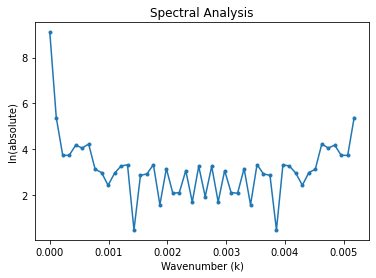

In [0]:
plt.plot(k, ln_abs, '.-')
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Cut-off Regional, Residual, Noise from Spectra

Text(0, 0.5, 'ln(absolute)')

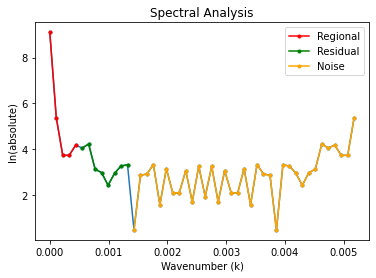

In [0]:
# guess the cutoff !!!
reg_cut = 5
res_cut = 13

k_reg_cut = k[:reg_cut]; ln_reg_cut = ln_abs[:reg_cut]
k_res_cut = k[reg_cut:res_cut]; ln_res_cut = ln_abs[reg_cut:res_cut]
k_noise_cut = k[res_cut:]; ln_noise_cut = ln_abs[res_cut:]

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')

plt.legend((p1[0], p2[0], p3[0]), ['Regional', 'Residual', 'Noise'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Determine window for Moving Average

#### Regression Function

In [0]:
def simple_linear_regression_traditional(x, y):
  import numpy as np
  x = np.array(x); y = np.array(y)
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  err_x = x - mean_x
  err_y = y - mean_y
  err_mult = err_x * err_y
  numerator = np.sum(err_mult)
  err_x_squared = err_x**2
  denominator = np.sum(err_x_squared)
  B1 = numerator / denominator
  B0 = mean_y - B1 * mean_x

  return(B0, B1) # B0 intercept, B1 gradient

#### Regression, calculate Cutt-off Frequency, calculate Window

In [0]:
#Regional Zone
B0, B1=simple_linear_regression_traditional(k_reg_cut, ln_reg_cut)

#Residual Zone
B2, B3=simple_linear_regression_traditional(k_res_cut, ln_res_cut)

# cut-off
cut_off = (B2-B0)/(B1-B3)

# window
windows = 2*np.pi/((fourier_data.Interval[3]-fourier_data.Interval[2])*cut_off)

print("Calculated window: ",windows, "\n")
print("Intercept for Regional Zone: ",B0)
print("Gradient for Regional Zone: ",B1)
print("Intercept for Residual Zone: ",B2)
print("Gradient for Residual Zone: ",B3)
print("Cut-off frequency: ",cut_off)

Calculated window:  15.355375527446293 

Intercept for Regional Zone:  7.527979325099439
Gradient for Regional Zone:  -10465.703027610054
Intercept for Residual Zone:  4.400934864109847
Gradient for Residual Zone:  -1191.588281479047
Cut-off frequency:  0.00033717983296401835


#### Windowing rule

Window must be an **odd number**. Rule and example:

* 1.25 rounded to 1. 1 is odd, so window = 1
* 1.75 rounded to 2. 2 is even, so window = 2 - 1 = 1
* 2.25 rounded to 2. 2 is even, so window = 2 + 1 = 3
* 2.75 rounded to 3. 3 is even, so window = 3

In [0]:
rounded = np.round(windows)

if rounded % 2 == 0:
  # even
  if (rounded - windows) > 0:
    window = rounded - 1
  if (rounded - windows) < 0:
    window = rounded + 1
else:
  # odd
  window = rounded

print("Selected odd window is:", window)

Selected odd window is: 15.0


#### Plot regression of spectrum

Text(0, 0.5, 'ln(absolute)')

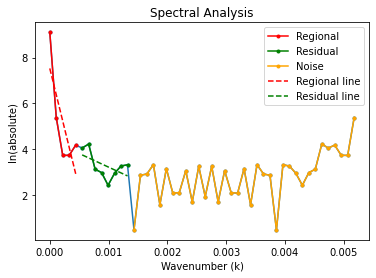

In [0]:
y_reg = B0 + B1 * k_reg_cut
y_res = B2 + B3 * k_res_cut

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')
p4 = plt.plot(k_reg_cut, y_reg, '--', color='red')
p5 = plt.plot(k_res_cut, y_res, '--', color='green')

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ['Regional', 'Residual', 'Noise', 'Regional line', 'Residual line'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Moving Average (Regional Separation)

In [0]:
regional = fourier_data.CBA.rolling(window=(int(window))).mean()

### Residual Separation

In [0]:
residual = fourier_data.CBA - regional

### Print dataframe

In [0]:
mva = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "Interval": data.Interval, "CBA": data.CBA, "Regional": regional, "Residual": residual})
mva.head(20)

,UTM_X,UTM_Y,Interval,CBA,Regional,Residual
0,302531.741108,4.232580e+06,0.000000,-205.232592,NaN,NaN
1,302531.741108,4.233793e+06,1213.550449,-204.659708,NaN,NaN
2,302531.741108,4.235007e+06,2427.100898,-204.668045,NaN,NaN
3,302531.741108,4.236220e+06,3640.651347,-201.718622,NaN,NaN
4,302531.741108,4.237434e+06,4854.201796,-200.246995,NaN,NaN
5,302531.741108,4.238648e+06,6067.752245,-196.424674,NaN,NaN
6,302531.741108,4.239861e+06,7281.302694,-191.891713,NaN,NaN
7,302531.741108,4.241075e+06,8494.853143,-190.022098,NaN,NaN
8,302531.741108,4.242288e+06,9708.403592,-191.161895,NaN,NaN
9,302531.741108,4.243502e+06,10921.954041,-193.808854,NaN,NaN


### Plot CBA, Regional, Residual Slice

Text(0, 0.5, 'Regional anomaly (mgal)')

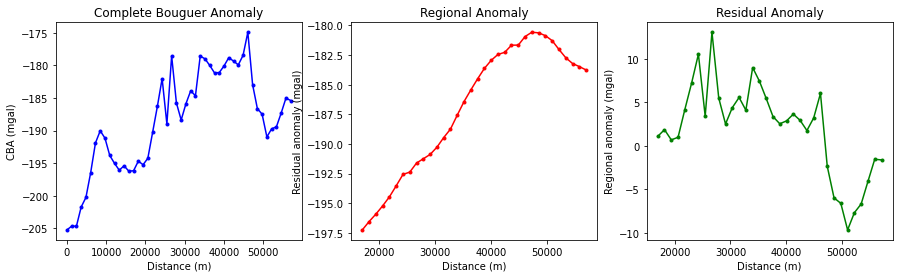

In [0]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(mva.Interval, mva.CBA, '.-', color='blue')
plt.title('Complete Bouguer Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('CBA (mgal)')
plt.subplot(1,3,2)
plt.plot(mva.Interval, mva.Regional, '.-', color='red')
plt.title('Regional Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Residual anomaly (mgal)')
plt.subplot(1,3,3)
plt.plot(mva.Interval, mva.Residual, '.-', color='green')
plt.title('Residual Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Regional anomaly (mgal)')

### Save data into CSV

In [0]:
mva.to_csv('/content/fft_N-S_1.csv') 

## North-South Slice 2

In [0]:
# N-S slice

loc = 25

x_slice = []
for k in range(len(xi)):
  xslice = xi[k][loc]
  x_slice.append(float(xslice))
x_slice = np.array(x_slice)
print('Coordinate slice in X direction:', x_slice, '\n')

y_slice = []
for k in range(len(xi)):
  yslice = yi[k][k]
  y_slice.append(float(yslice))
y_slice = np.array(y_slice)
print('Coordinate slice in Y direction:', y_slice, '\n')

g_slice = []
for k in range(len(xi)):
  gslice = zi[k][loc]
  g_slice.append(float(gslice))
g_slice = np.array(g_slice)
print('CBA on slice:', g_slice)

Coordinate slice in X direction: [325143.57572041 325143.57572041 325143.57572041 325143.57572041
 325143.57572041 325143.57572041 325143.57572041 325143.57572041
 325143.57572041 325143.57572041 325143.57572041 325143.57572041
 325143.57572041 325143.57572041 325143.57572041 325143.57572041
 325143.57572041 325143.57572041 325143.57572041 325143.57572041
 325143.57572041 325143.57572041 325143.57572041 325143.57572041
 325143.57572041 325143.57572041 325143.57572041 325143.57572041
 325143.57572041 325143.57572041 325143.57572041 325143.57572041
 325143.57572041 325143.57572041 325143.57572041 325143.57572041
 325143.57572041 325143.57572041 325143.57572041 325143.57572041
 325143.57572041 325143.57572041 325143.57572041 325143.57572041
 325143.57572041 325143.57572041 325143.57572041 325143.57572041
 325143.57572041 325143.57572041] 

Coordinate slice in Y direction: [4231366.251      4232579.80144898 4233793.35189796 4235006.90234694
 4236220.45279592 4237434.0032449  4238647.553693

Visualize the slice

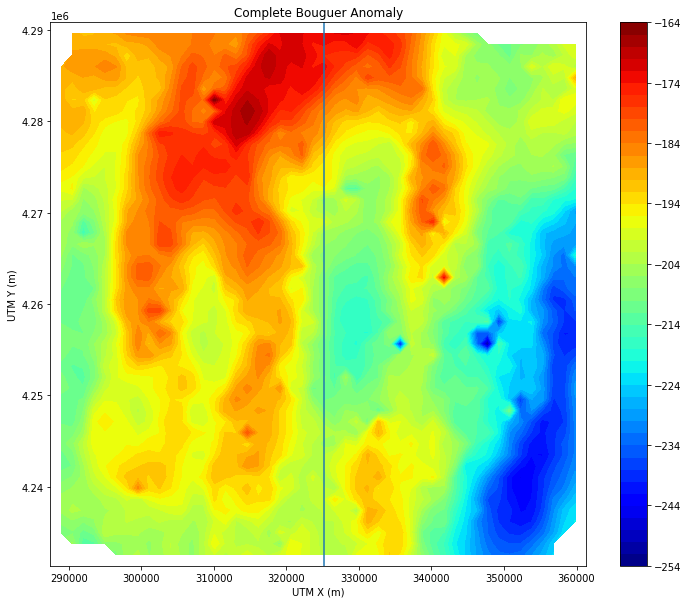

In [0]:
import scipy
from scipy.interpolate import griddata

xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)
# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi),method='cubic')

fig, ax = plt.subplots(figsize=(12,10))
# plot CBA contours
im = ax.contourf(xi,yi,zi,levels=50, cmap="jet")
ax.set_title('Complete Bouguer Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
fig.colorbar(im)

im = plt.plot(x_slice, y_slice)

### Data preparation for FFT

Create dataframe

In [0]:
data = pd.DataFrame({"UTM_X": x_slice, "UTM_Y": y_slice, "CBA": g_slice})
data.head(10)

,UTM_X,UTM_Y,CBA
0,325143.57572,4.231366e+06,NaN
1,325143.57572,4.232580e+06,-202.816232
2,325143.57572,4.233793e+06,-202.917491
3,325143.57572,4.235007e+06,-203.485528
4,325143.57572,4.236220e+06,-202.037261
5,325143.57572,4.237434e+06,-201.751903
6,325143.57572,4.238648e+06,-200.612191
7,325143.57572,4.239861e+06,-201.585213
8,325143.57572,4.241075e+06,-204.161423
9,325143.57572,4.242288e+06,-202.079353


Remove NaN from dataframe

In [0]:
# look up the number of rows with NaN data
print("Original size of data:", len(data), "rows")
print("How many data with NaN values?")
print(data.isnull().sum())

# drop rows with missing values
data.dropna(inplace=True)
# re-index dataframe
data = data.reset_index(drop=True)
print("NaN has successfully been deleted")
data.head(10)

Original size of data: 50 rows
How many data with NaN values?
UTM_X    0
UTM_Y    0
CBA      2
dtype: int64
NaN has successfully been deleted


,UTM_X,UTM_Y,CBA
0,325143.57572,4.232580e+06,-202.816232
1,325143.57572,4.233793e+06,-202.917491
2,325143.57572,4.235007e+06,-203.485528
3,325143.57572,4.236220e+06,-202.037261
4,325143.57572,4.237434e+06,-201.751903
5,325143.57572,4.238648e+06,-200.612191
6,325143.57572,4.239861e+06,-201.585213
7,325143.57572,4.241075e+06,-204.161423
8,325143.57572,4.242288e+06,-202.079353
9,325143.57572,4.243502e+06,-202.242798


Calculate interval on slice

In [0]:
# calculate distance on slice from the first point on slice
dist_x = np.array([j-i for i, j in zip(data.UTM_X[:-1], data.UTM_X[1:])])
dist_y = np.array([j-i for i, j in zip(data.UTM_Y[:-1], data.UTM_Y[1:])])
dist = np.sqrt((dist_x**2) + (dist_y**2))
dist = np.cumsum(dist)
dist = np.append(0, dist)

Put interval into dataframe

In [0]:
data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": dist})
data.head(10)

,UTM_X,UTM_Y,CBA,Interval
0,325143.57572,4.232580e+06,-202.816232,0.000000
1,325143.57572,4.233793e+06,-202.917491,1213.550449
2,325143.57572,4.235007e+06,-203.485528,2427.100898
3,325143.57572,4.236220e+06,-202.037261,3640.651347
4,325143.57572,4.237434e+06,-201.751903,4854.201796
5,325143.57572,4.238648e+06,-200.612191,6067.752245
6,325143.57572,4.239861e+06,-201.585213,7281.302694
7,325143.57572,4.241075e+06,-204.161423,8494.853143
8,325143.57572,4.242288e+06,-202.079353,9708.403592
9,325143.57572,4.243502e+06,-202.242798,10921.954041


### Fourier Transform

In [0]:
def dft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

fourier = np.fft.fft(data.CBA)
print(len(fourier))

48


In [0]:
imaginary = fourier.imag
real = fourier.real
absolute = np.sqrt((imaginary**2) + (real**2))
ln_abs = np.log(absolute)

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute
0,325143.57572,4.232580e+06,-202.816232,0.000000,-9542.888373+0.000000j,-9542.888373,0.000000,9542.888373,9.163551
1,325143.57572,4.233793e+06,-202.917491,1213.550449,242.166264+216.719734j,242.166264,216.719734,324.979911,5.783763
2,325143.57572,4.235007e+06,-203.485528,2427.100898,6.555587+123.342768j,6.555587,123.342768,123.516858,4.816378
3,325143.57572,4.236220e+06,-202.037261,3640.651347,-33.548099+83.970205j,-33.548099,83.970205,90.423837,4.504508
4,325143.57572,4.237434e+06,-201.751903,4854.201796,-15.903597+74.175208j,-15.903597,74.175208,75.860964,4.328902
5,325143.57572,4.238648e+06,-200.612191,6067.752245,-17.217452+45.043955j,-17.217452,45.043955,48.222386,3.875823
6,325143.57572,4.239861e+06,-201.585213,7281.302694,-31.599625+31.074521j,-31.599625,31.074521,44.318870,3.791411
7,325143.57572,4.241075e+06,-204.161423,8494.853143,-16.553892+24.968775j,-16.553892,24.968775,29.957822,3.399790
8,325143.57572,4.242288e+06,-202.079353,9708.403592,-8.605635+34.635486j,-8.605635,34.635486,35.688567,3.574830
9,325143.57572,4.243502e+06,-202.242798,10921.954041,-8.793820+16.949319j,-8.793820,16.949319,19.094781,2.949415


Compute sampling frequency

In [0]:
# compute freq sampling
interval_last = fourier_data.Interval.iloc[-1]
minus = interval_last - fourier_data.Interval.iloc[0]

f_s = 0 # initial freq sampling
f_sample = []
for i in range(0,len(fourier_data.CBA)-1):
  f_s = f_s + (1 / minus)
  f_sample.append(float(f_s))
f_sample = np.append(0, f_sample)

# put into dataframe
fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample
0,325143.57572,4.232580e+06,-202.816232,0.000000,-9542.888373+0.000000j,-9542.888373,0.000000,9542.888373,9.163551,0.000000
1,325143.57572,4.233793e+06,-202.917491,1213.550449,242.166264+216.719734j,242.166264,216.719734,324.979911,5.783763,0.000018
2,325143.57572,4.235007e+06,-203.485528,2427.100898,6.555587+123.342768j,6.555587,123.342768,123.516858,4.816378,0.000035
3,325143.57572,4.236220e+06,-202.037261,3640.651347,-33.548099+83.970205j,-33.548099,83.970205,90.423837,4.504508,0.000053
4,325143.57572,4.237434e+06,-201.751903,4854.201796,-15.903597+74.175208j,-15.903597,74.175208,75.860964,4.328902,0.000070
5,325143.57572,4.238648e+06,-200.612191,6067.752245,-17.217452+45.043955j,-17.217452,45.043955,48.222386,3.875823,0.000088
6,325143.57572,4.239861e+06,-201.585213,7281.302694,-31.599625+31.074521j,-31.599625,31.074521,44.318870,3.791411,0.000105
7,325143.57572,4.241075e+06,-204.161423,8494.853143,-16.553892+24.968775j,-16.553892,24.968775,29.957822,3.399790,0.000123
8,325143.57572,4.242288e+06,-202.079353,9708.403592,-8.605635+34.635486j,-8.605635,34.635486,35.688567,3.574830,0.000140
9,325143.57572,4.243502e+06,-202.242798,10921.954041,-8.793820+16.949319j,-8.793820,16.949319,19.094781,2.949415,0.000158


Wavenumber

In [0]:
k = 2 * np.pi * f_sample

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample, "Wavenumber": k})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample,Wavenumber
0,325143.57572,4.232580e+06,-202.816232,0.000000,-9542.888373+0.000000j,-9542.888373,0.000000,9542.888373,9.163551,0.000000,0.000000
1,325143.57572,4.233793e+06,-202.917491,1213.550449,242.166264+216.719734j,242.166264,216.719734,324.979911,5.783763,0.000018,0.000110
2,325143.57572,4.235007e+06,-203.485528,2427.100898,6.555587+123.342768j,6.555587,123.342768,123.516858,4.816378,0.000035,0.000220
3,325143.57572,4.236220e+06,-202.037261,3640.651347,-33.548099+83.970205j,-33.548099,83.970205,90.423837,4.504508,0.000053,0.000330
4,325143.57572,4.237434e+06,-201.751903,4854.201796,-15.903597+74.175208j,-15.903597,74.175208,75.860964,4.328902,0.000070,0.000441
5,325143.57572,4.238648e+06,-200.612191,6067.752245,-17.217452+45.043955j,-17.217452,45.043955,48.222386,3.875823,0.000088,0.000551
6,325143.57572,4.239861e+06,-201.585213,7281.302694,-31.599625+31.074521j,-31.599625,31.074521,44.318870,3.791411,0.000105,0.000661
7,325143.57572,4.241075e+06,-204.161423,8494.853143,-16.553892+24.968775j,-16.553892,24.968775,29.957822,3.399790,0.000123,0.000771
8,325143.57572,4.242288e+06,-202.079353,9708.403592,-8.605635+34.635486j,-8.605635,34.635486,35.688567,3.574830,0.000140,0.000881
9,325143.57572,4.243502e+06,-202.242798,10921.954041,-8.793820+16.949319j,-8.793820,16.949319,19.094781,2.949415,0.000158,0.000991


Plot Spectrum

Text(0, 0.5, 'ln(absolute)')

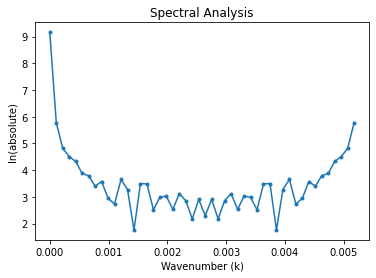

In [0]:
plt.plot(k, ln_abs, '.-')
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Cut-off Regional, Residual, Noise from Spectra

Text(0, 0.5, 'ln(absolute)')

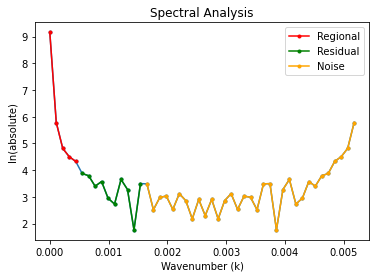

In [0]:
# guess the cutoff !!!
reg_cut = 5
res_cut = 15

k_reg_cut = k[:reg_cut]; ln_reg_cut = ln_abs[:reg_cut]
k_res_cut = k[reg_cut:res_cut]; ln_res_cut = ln_abs[reg_cut:res_cut]
k_noise_cut = k[res_cut:]; ln_noise_cut = ln_abs[res_cut:]

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')

plt.legend((p1[0], p2[0], p3[0]), ['Regional', 'Residual', 'Noise'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Determine window for Moving Average

#### Regression Function

In [0]:
def simple_linear_regression_traditional(x, y):
  import numpy as np
  x = np.array(x); y = np.array(y)
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  err_x = x - mean_x
  err_y = y - mean_y
  err_mult = err_x * err_y
  numerator = np.sum(err_mult)
  err_x_squared = err_x**2
  denominator = np.sum(err_x_squared)
  B1 = numerator / denominator
  B0 = mean_y - B1 * mean_x

  return(B0, B1) # B0 intercept, B1 gradient

#### Regression, calculate Cutt-off Frequency, calculate Window

In [0]:
#Regional Zone
B0, B1=simple_linear_regression_traditional(k_reg_cut, ln_reg_cut)

#Residual Zone
B2, B3=simple_linear_regression_traditional(k_res_cut, ln_res_cut)

# cut-off
cut_off = (B2-B0)/(B1-B3)

# window
windows = 2*np.pi/((fourier_data.Interval[3]-fourier_data.Interval[2])*cut_off)

print("Calculated window: ",windows, "\n")
print("Intercept for Regional Zone: ",B0)
print("Gradient for Regional Zone: ",B1)
print("Intercept for Residual Zone: ",B2)
print("Gradient for Residual Zone: ",B3)
print("Cut-off frequency: ",cut_off)

Calculated window:  12.819221210367187 

Intercept for Regional Zone:  7.909131316526267
Gradient for Regional Zone:  -9938.768758517805
Intercept for Residual Zone:  4.299636130961419
Gradient for Residual Zone:  -1001.8856892003197
Cut-off frequency:  0.00040388748040769736


#### Windowing rule

Window must be an **odd number**. Rule and example:

* 1.25 rounded to 1. 1 is odd, so window = 1
* 1.75 rounded to 2. 2 is even, so window = 2 - 1 = 1
* 2.25 rounded to 2. 2 is even, so window = 2 + 1 = 3
* 2.75 rounded to 3. 3 is even, so window = 3

In [0]:
rounded = np.round(windows)

if rounded % 2 == 0:
  # even
  if (rounded - windows) > 0:
    window = rounded - 1
  if (rounded - windows) < 0:
    window = rounded + 1
else:
  # odd
  window = rounded

print("Selected odd window is:", window)

Selected odd window is: 13.0


#### Plot regression of spectrum

Text(0, 0.5, 'ln(absolute)')

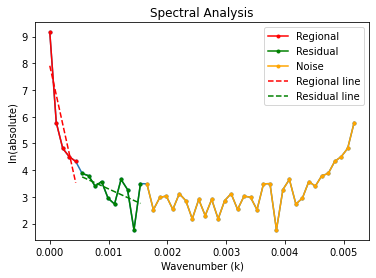

In [0]:
y_reg = B0 + B1 * k_reg_cut
y_res = B2 + B3 * k_res_cut

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')
p4 = plt.plot(k_reg_cut, y_reg, '--', color='red')
p5 = plt.plot(k_res_cut, y_res, '--', color='green')

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ['Regional', 'Residual', 'Noise', 'Regional line', 'Residual line'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Moving Average (Regional Separation)

In [0]:
regional = fourier_data.CBA.rolling(window=(int(window))).mean()

### Residual Separation

In [0]:
residual = fourier_data.CBA - regional

### Print dataframe

In [0]:
mva = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "Interval": data.Interval, "CBA": data.CBA, "Regional": regional, "Residual": residual})
mva.head(20)

,UTM_X,UTM_Y,Interval,CBA,Regional,Residual
0,325143.57572,4.232580e+06,0.000000,-202.816232,NaN,NaN
1,325143.57572,4.233793e+06,1213.550449,-202.917491,NaN,NaN
2,325143.57572,4.235007e+06,2427.100898,-203.485528,NaN,NaN
3,325143.57572,4.236220e+06,3640.651347,-202.037261,NaN,NaN
4,325143.57572,4.237434e+06,4854.201796,-201.751903,NaN,NaN
5,325143.57572,4.238648e+06,6067.752245,-200.612191,NaN,NaN
6,325143.57572,4.239861e+06,7281.302694,-201.585213,NaN,NaN
7,325143.57572,4.241075e+06,8494.853143,-204.161423,NaN,NaN
8,325143.57572,4.242288e+06,9708.403592,-202.079353,NaN,NaN
9,325143.57572,4.243502e+06,10921.954041,-202.242798,NaN,NaN


### Plot CBA, Regional, Residual Slice

Text(0, 0.5, 'Regional anomaly (mgal)')

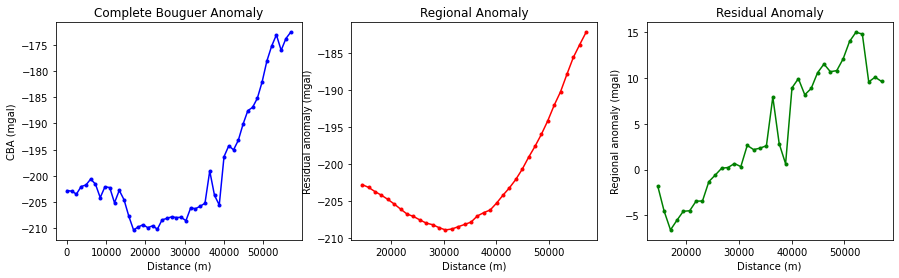

In [0]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(mva.Interval, mva.CBA, '.-', color='blue')
plt.title('Complete Bouguer Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('CBA (mgal)')
plt.subplot(1,3,2)
plt.plot(mva.Interval, mva.Regional, '.-', color='red')
plt.title('Regional Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Residual anomaly (mgal)')
plt.subplot(1,3,3)
plt.plot(mva.Interval, mva.Residual, '.-', color='green')
plt.title('Residual Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Regional anomaly (mgal)')

### Save data into CSV

In [0]:
mva.to_csv('/content/fft_N-S_2.csv') 

## North-South Slice 3

In [0]:
# N-S slice

loc = 40

x_slice = []
for k in range(len(xi)):
  xslice = xi[k][loc]
  x_slice.append(float(xslice))
x_slice = np.array(x_slice)
print('Coordinate slice in X direction:', x_slice, '\n')

y_slice = []
for k in range(len(xi)):
  yslice = yi[k][k]
  y_slice.append(float(yslice))
y_slice = np.array(y_slice)
print('Coordinate slice in Y direction:', y_slice, '\n')

g_slice = []
for k in range(len(xi)):
  gslice = zi[k][loc]
  g_slice.append(float(gslice))
g_slice = np.array(g_slice)
print('CBA on slice:', g_slice)

Coordinate slice in X direction: [347755.41033265 347755.41033265 347755.41033265 347755.41033265
 347755.41033265 347755.41033265 347755.41033265 347755.41033265
 347755.41033265 347755.41033265 347755.41033265 347755.41033265
 347755.41033265 347755.41033265 347755.41033265 347755.41033265
 347755.41033265 347755.41033265 347755.41033265 347755.41033265
 347755.41033265 347755.41033265 347755.41033265 347755.41033265
 347755.41033265 347755.41033265 347755.41033265 347755.41033265
 347755.41033265 347755.41033265 347755.41033265 347755.41033265
 347755.41033265 347755.41033265 347755.41033265 347755.41033265
 347755.41033265 347755.41033265 347755.41033265 347755.41033265
 347755.41033265 347755.41033265 347755.41033265 347755.41033265
 347755.41033265 347755.41033265 347755.41033265 347755.41033265
 347755.41033265 347755.41033265] 

Coordinate slice in Y direction: [4231366.251      4232579.80144898 4233793.35189796 4235006.90234694
 4236220.45279592 4237434.0032449  4238647.553693

Visualize the slice

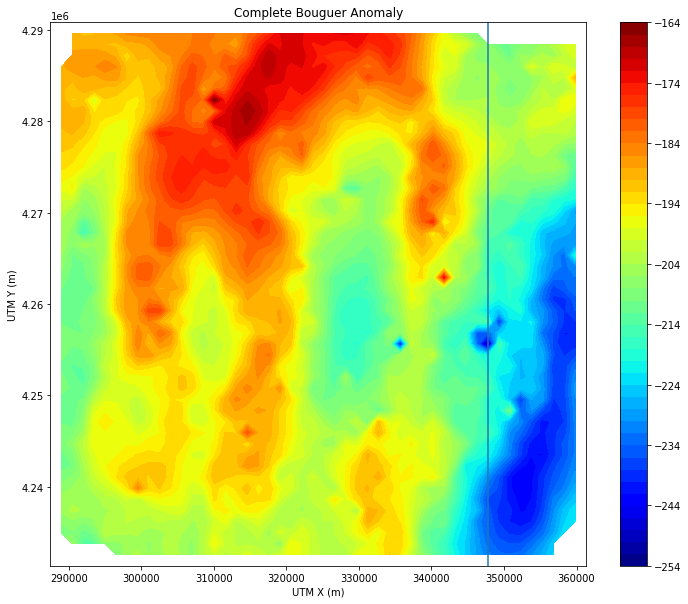

In [0]:
import scipy
from scipy.interpolate import griddata

xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)
# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi),method='cubic')

fig, ax = plt.subplots(figsize=(12,10))
# plot CBA contours
im = ax.contourf(xi,yi,zi,levels=50, cmap="jet")
ax.set_title('Complete Bouguer Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
fig.colorbar(im)

im = plt.plot(x_slice, y_slice)

### Data preparation for FFT

Create dataframe

In [0]:
data = pd.DataFrame({"UTM_X": x_slice, "UTM_Y": y_slice, "CBA": g_slice})
data.head(10)

,UTM_X,UTM_Y,CBA
0,347755.410333,4.231366e+06,NaN
1,347755.410333,4.232580e+06,-231.412498
2,347755.410333,4.233793e+06,-232.927192
3,347755.410333,4.235007e+06,-234.186048
4,347755.410333,4.236220e+06,-234.247820
5,347755.410333,4.237434e+06,-235.091839
6,347755.410333,4.238648e+06,-236.201490
7,347755.410333,4.239861e+06,-233.487265
8,347755.410333,4.241075e+06,-230.214516
9,347755.410333,4.242288e+06,-224.499779


Remove NaN from dataframe

In [0]:
# look up the number of rows with NaN data
print("Original size of data:", len(data), "rows")
print("How many data with NaN values?")
print(data.isnull().sum())

# drop rows with missing values
data.dropna(inplace=True)
# re-index dataframe
data = data.reset_index(drop=True)
print("NaN has successfully been deleted")
data.head(10)

Original size of data: 50 rows
How many data with NaN values?
UTM_X    0
UTM_Y    0
CBA      3
dtype: int64
NaN has successfully been deleted


,UTM_X,UTM_Y,CBA
0,347755.410333,4.232580e+06,-231.412498
1,347755.410333,4.233793e+06,-232.927192
2,347755.410333,4.235007e+06,-234.186048
3,347755.410333,4.236220e+06,-234.247820
4,347755.410333,4.237434e+06,-235.091839
5,347755.410333,4.238648e+06,-236.201490
6,347755.410333,4.239861e+06,-233.487265
7,347755.410333,4.241075e+06,-230.214516
8,347755.410333,4.242288e+06,-224.499779
9,347755.410333,4.243502e+06,-220.371855


Calculate interval on slice

In [0]:
# calculate distance on slice from the first point on slice
dist_x = np.array([j-i for i, j in zip(data.UTM_X[:-1], data.UTM_X[1:])])
dist_y = np.array([j-i for i, j in zip(data.UTM_Y[:-1], data.UTM_Y[1:])])
dist = np.sqrt((dist_x**2) + (dist_y**2))
dist = np.cumsum(dist)
dist = np.append(0, dist)

Put interval into dataframe

In [0]:
data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": dist})
data.head(10)

,UTM_X,UTM_Y,CBA,Interval
0,347755.410333,4.232580e+06,-231.412498,0.000000
1,347755.410333,4.233793e+06,-232.927192,1213.550449
2,347755.410333,4.235007e+06,-234.186048,2427.100898
3,347755.410333,4.236220e+06,-234.247820,3640.651347
4,347755.410333,4.237434e+06,-235.091839,4854.201796
5,347755.410333,4.238648e+06,-236.201490,6067.752245
6,347755.410333,4.239861e+06,-233.487265,7281.302694
7,347755.410333,4.241075e+06,-230.214516,8494.853143
8,347755.410333,4.242288e+06,-224.499779,9708.403592
9,347755.410333,4.243502e+06,-220.371855,10921.954041


### Fourier Transform

In [0]:
def dft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

fourier = np.fft.fft(data.CBA)
print(len(fourier))

47


In [0]:
imaginary = fourier.imag
real = fourier.real
absolute = np.sqrt((imaginary**2) + (real**2))
ln_abs = np.log(absolute)

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute
0,347755.410333,4.232580e+06,-231.412498,0.000000,-10176.726986+0.000000j,-10176.726986,0.000000,10176.726986,9.227859
1,347755.410333,4.233793e+06,-232.927192,1213.550449,-14.876594+268.242960j,-14.876594,268.242960,268.655167,5.593429
2,347755.410333,4.235007e+06,-234.186048,2427.100898,-147.002748+105.624206j,-147.002748,105.624206,181.014588,5.198578
3,347755.410333,4.236220e+06,-234.247820,3640.651347,-26.517383+130.307149j,-26.517383,130.307149,132.977910,4.890183
4,347755.410333,4.237434e+06,-235.091839,4854.201796,66.346001+9.497261j,66.346001,9.497261,67.022308,4.205026
5,347755.410333,4.238648e+06,-236.201490,6067.752245,-38.827936+59.121970j,-38.827936,59.121970,70.732001,4.258898
6,347755.410333,4.239861e+06,-233.487265,7281.302694,37.583246+31.028793j,37.583246,31.028793,48.736909,3.886437
7,347755.410333,4.241075e+06,-230.214516,8494.853143,-58.829253-19.480103j,-58.829253,-19.480103,61.970601,4.126660
8,347755.410333,4.242288e+06,-224.499779,9708.403592,-10.175835+59.341333j,-10.175835,59.341333,60.207487,4.097797
9,347755.410333,4.243502e+06,-220.371855,10921.954041,11.096557-13.135661j,11.096557,-13.135661,17.195324,2.844637


Compute sampling frequency

In [0]:
# compute freq sampling
interval_last = fourier_data.Interval.iloc[-1]
minus = interval_last - fourier_data.Interval.iloc[0]

f_s = 0 # initial freq sampling
f_sample = []
for i in range(0,len(fourier_data.CBA)-1):
  f_s = f_s + (1 / minus)
  f_sample.append(float(f_s))
f_sample = np.append(0, f_sample)

# put into dataframe
fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample
0,347755.410333,4.232580e+06,-231.412498,0.000000,-10176.726986+0.000000j,-10176.726986,0.000000,10176.726986,9.227859,0.000000
1,347755.410333,4.233793e+06,-232.927192,1213.550449,-14.876594+268.242960j,-14.876594,268.242960,268.655167,5.593429,0.000018
2,347755.410333,4.235007e+06,-234.186048,2427.100898,-147.002748+105.624206j,-147.002748,105.624206,181.014588,5.198578,0.000036
3,347755.410333,4.236220e+06,-234.247820,3640.651347,-26.517383+130.307149j,-26.517383,130.307149,132.977910,4.890183,0.000054
4,347755.410333,4.237434e+06,-235.091839,4854.201796,66.346001+9.497261j,66.346001,9.497261,67.022308,4.205026,0.000072
5,347755.410333,4.238648e+06,-236.201490,6067.752245,-38.827936+59.121970j,-38.827936,59.121970,70.732001,4.258898,0.000090
6,347755.410333,4.239861e+06,-233.487265,7281.302694,37.583246+31.028793j,37.583246,31.028793,48.736909,3.886437,0.000107
7,347755.410333,4.241075e+06,-230.214516,8494.853143,-58.829253-19.480103j,-58.829253,-19.480103,61.970601,4.126660,0.000125
8,347755.410333,4.242288e+06,-224.499779,9708.403592,-10.175835+59.341333j,-10.175835,59.341333,60.207487,4.097797,0.000143
9,347755.410333,4.243502e+06,-220.371855,10921.954041,11.096557-13.135661j,11.096557,-13.135661,17.195324,2.844637,0.000161


Wavenumber

In [0]:
k = 2 * np.pi * f_sample

fourier_data = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "CBA": data.CBA, "Interval": data.Interval, 
                             "FFT": fourier, "Real": real, "Imaginary": imaginary, "Absolute": absolute,
                             "LnAbsolute": ln_abs, "FreqSample": f_sample, "Wavenumber": k})
fourier_data.head(10)

,UTM_X,UTM_Y,CBA,Interval,FFT,Real,Imaginary,Absolute,LnAbsolute,FreqSample,Wavenumber
0,347755.410333,4.232580e+06,-231.412498,0.000000,-10176.726986+0.000000j,-10176.726986,0.000000,10176.726986,9.227859,0.000000,0.000000
1,347755.410333,4.233793e+06,-232.927192,1213.550449,-14.876594+268.242960j,-14.876594,268.242960,268.655167,5.593429,0.000018,0.000113
2,347755.410333,4.235007e+06,-234.186048,2427.100898,-147.002748+105.624206j,-147.002748,105.624206,181.014588,5.198578,0.000036,0.000225
3,347755.410333,4.236220e+06,-234.247820,3640.651347,-26.517383+130.307149j,-26.517383,130.307149,132.977910,4.890183,0.000054,0.000338
4,347755.410333,4.237434e+06,-235.091839,4854.201796,66.346001+9.497261j,66.346001,9.497261,67.022308,4.205026,0.000072,0.000450
5,347755.410333,4.238648e+06,-236.201490,6067.752245,-38.827936+59.121970j,-38.827936,59.121970,70.732001,4.258898,0.000090,0.000563
6,347755.410333,4.239861e+06,-233.487265,7281.302694,37.583246+31.028793j,37.583246,31.028793,48.736909,3.886437,0.000107,0.000675
7,347755.410333,4.241075e+06,-230.214516,8494.853143,-58.829253-19.480103j,-58.829253,-19.480103,61.970601,4.126660,0.000125,0.000788
8,347755.410333,4.242288e+06,-224.499779,9708.403592,-10.175835+59.341333j,-10.175835,59.341333,60.207487,4.097797,0.000143,0.000900
9,347755.410333,4.243502e+06,-220.371855,10921.954041,11.096557-13.135661j,11.096557,-13.135661,17.195324,2.844637,0.000161,0.001013


Plot Spectrum

Text(0, 0.5, 'ln(absolute)')

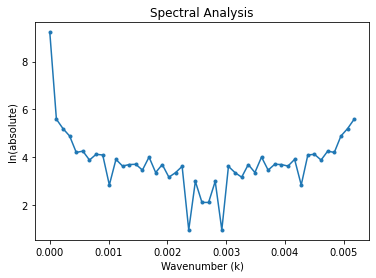

In [0]:
plt.plot(k, ln_abs, '.-')
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Cut-off Regional, Residual, Noise from Spectra

Text(0, 0.5, 'ln(absolute)')

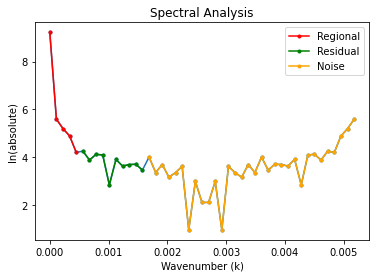

In [0]:
# guess the cutoff !!!
reg_cut = 5
res_cut = 15

k_reg_cut = k[:reg_cut]; ln_reg_cut = ln_abs[:reg_cut]
k_res_cut = k[reg_cut:res_cut]; ln_res_cut = ln_abs[reg_cut:res_cut]
k_noise_cut = k[res_cut:]; ln_noise_cut = ln_abs[res_cut:]

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')

plt.legend((p1[0], p2[0], p3[0]), ['Regional', 'Residual', 'Noise'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Determine window for Moving Average

#### Regression Function

In [0]:
def simple_linear_regression_traditional(x, y):
  import numpy as np
  x = np.array(x); y = np.array(y)
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  err_x = x - mean_x
  err_y = y - mean_y
  err_mult = err_x * err_y
  numerator = np.sum(err_mult)
  err_x_squared = err_x**2
  denominator = np.sum(err_x_squared)
  B1 = numerator / denominator
  B0 = mean_y - B1 * mean_x

  return(B0, B1) # B0 intercept, B1 gradient

#### Regression, calculate Cutt-off Frequency, calculate Window

In [0]:
#Regional Zone
B0, B1=simple_linear_regression_traditional(k_reg_cut, ln_reg_cut)

#Residual Zone
B2, B3=simple_linear_regression_traditional(k_res_cut, ln_res_cut)

# cut-off
cut_off = (B2-B0)/(B1-B3)

# window
windows = 2*np.pi/((fourier_data.Interval[3]-fourier_data.Interval[2])*cut_off)

print("Calculated window: ",windows, "\n")
print("Intercept for Regional Zone: ",B0)
print("Gradient for Regional Zone: ",B1)
print("Intercept for Residual Zone: ",B2)
print("Gradient for Residual Zone: ",B3)
print("Cut-off frequency: ",cut_off)

Calculated window:  12.94851111889444 

Intercept for Regional Zone:  7.972797114749337
Gradient for Regional Zone:  -9549.93261459015
Intercept for Residual Zone:  4.387417711252034
Gradient for Residual Zone:  -583.2268228129923
Cut-off frequency:  0.00039985469432768107


#### Windowing rule

Window must be an **odd number**. Rule and example:

* 1.25 rounded to 1. 1 is odd, so window = 1
* 1.75 rounded to 2. 2 is even, so window = 2 - 1 = 1
* 2.25 rounded to 2. 2 is even, so window = 2 + 1 = 3
* 2.75 rounded to 3. 3 is even, so window = 3

In [0]:
rounded = np.round(windows)

if rounded % 2 == 0:
  # even
  if (rounded - windows) > 0:
    window = rounded - 1
  if (rounded - windows) < 0:
    window = rounded + 1
else:
  # odd
  window = rounded

print("Selected odd window is:", window)

Selected odd window is: 13.0


#### Plot regression of spectrum

Text(0, 0.5, 'ln(absolute)')

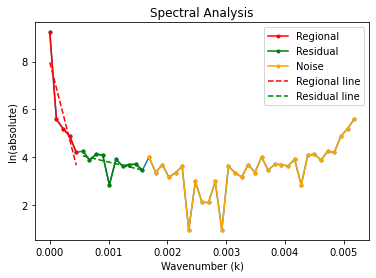

In [0]:
y_reg = B0 + B1 * k_reg_cut
y_res = B2 + B3 * k_res_cut

plt.plot(k, ln_abs, '.-')
p1 = plt.plot(k_reg_cut, ln_reg_cut, '.-', color='red')
p2 = plt.plot(k_res_cut, ln_res_cut, '.-', color='green')
p3 = plt.plot(k_noise_cut, ln_noise_cut, '.-', color='orange')
p4 = plt.plot(k_reg_cut, y_reg, '--', color='red')
p5 = plt.plot(k_res_cut, y_res, '--', color='green')

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ['Regional', 'Residual', 'Noise', 'Regional line', 'Residual line'])
plt.title('Spectral Analysis')
plt.xlabel('Wavenumber (k)'); plt.ylabel('ln(absolute)')

### Moving Average (Regional Separation)

In [0]:
regional = fourier_data.CBA.rolling(window=(int(window))).mean()

### Residual Separation

In [0]:
residual = fourier_data.CBA - regional

### Print dataframe

In [0]:
mva = pd.DataFrame({"UTM_X": data.UTM_X, "UTM_Y": data.UTM_Y, "Interval": data.Interval, "CBA": data.CBA, "Regional": regional, "Residual": residual})
mva.head(20)

,UTM_X,UTM_Y,Interval,CBA,Regional,Residual
0,347755.410333,4.232580e+06,0.000000,-231.412498,NaN,NaN
1,347755.410333,4.233793e+06,1213.550449,-232.927192,NaN,NaN
2,347755.410333,4.235007e+06,2427.100898,-234.186048,NaN,NaN
3,347755.410333,4.236220e+06,3640.651347,-234.247820,NaN,NaN
4,347755.410333,4.237434e+06,4854.201796,-235.091839,NaN,NaN
5,347755.410333,4.238648e+06,6067.752245,-236.201490,NaN,NaN
6,347755.410333,4.239861e+06,7281.302694,-233.487265,NaN,NaN
7,347755.410333,4.241075e+06,8494.853143,-230.214516,NaN,NaN
8,347755.410333,4.242288e+06,9708.403592,-224.499779,NaN,NaN
9,347755.410333,4.243502e+06,10921.954041,-220.371855,NaN,NaN


### Plot CBA, Regional, Residual Slice

Text(0, 0.5, 'Regional anomaly (mgal)')

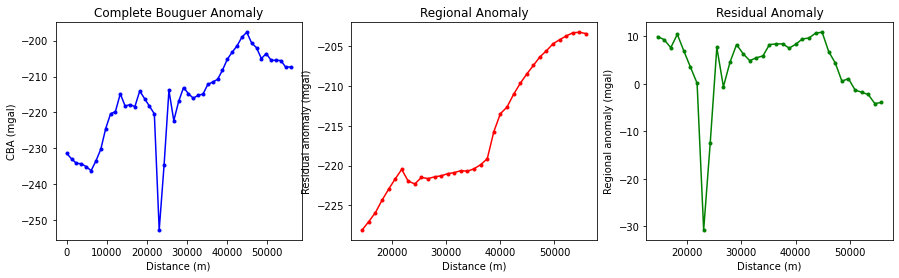

In [0]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(mva.Interval, mva.CBA, '.-', color='blue')
plt.title('Complete Bouguer Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('CBA (mgal)')
plt.subplot(1,3,2)
plt.plot(mva.Interval, mva.Regional, '.-', color='red')
plt.title('Regional Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Residual anomaly (mgal)')
plt.subplot(1,3,3)
plt.plot(mva.Interval, mva.Residual, '.-', color='green')
plt.title('Residual Anomaly')
plt.xlabel('Distance (m)'); plt.ylabel('Regional anomaly (mgal)')

### Save data into CSV

In [0]:
mva.to_csv('/content/fft_N-S_3.csv') 

## Create 2D Map of Resulted Slices Anomalies

Load slices anomaly results in CSV format

In [0]:
swne = pd.read_csv('/content/computational-geophysics/gravity/results/fft_SW-NE.csv')
senw = pd.read_csv('/content/computational-geophysics/gravity/results/fft_SE-NW.csv')
ew1 = pd.read_csv('/content/computational-geophysics/gravity/results/fft_E-W_1.csv')
ew2 = pd.read_csv('/content/computational-geophysics/gravity/results/fft_E-W_2.csv')
ew3 = pd.read_csv('/content/computational-geophysics/gravity/results/fft_E-W_3.csv')
ns1 = pd.read_csv('/content/computational-geophysics/gravity/results/fft_N-S_1.csv')
ns2 = pd.read_csv('/content/computational-geophysics/gravity/results/fft_N-S_2.csv')
ns3 = pd.read_csv('/content/computational-geophysics/gravity/results/fft_N-S_3.csv')

Append (concatenate) all data

In [0]:
utm_x_mva = np.concatenate((swne.UTM_X, ew1.UTM_X, ew2.UTM_X, ew3.UTM_X, ns1.UTM_X, ns2.UTM_X, ns3.UTM_X), axis=0)
utm_y_mva = np.concatenate((swne.UTM_Y, ew1.UTM_Y, ew2.UTM_Y, ew3.UTM_Y, ns1.UTM_Y, ns2.UTM_Y, ns3.UTM_Y), axis=0)
CBA_mva = np.concatenate((swne.CBA, ew1.CBA, ew2.CBA, ew3.CBA, ns1.CBA, ns2.CBA, ns3.CBA), axis=0)
regional_mva = np.concatenate((swne.Regional, ew1.Regional, ew2.Regional, ew3.Regional, ns1.Regional, ns2.Regional, ns3.Regional), axis=0)
residual_mva = np.concatenate((swne.Residual, ew1.Residual, ew2.Residual, ew3.Residual, ns1.Residual, ns2.Residual, ns3.Residual), axis=0)

In [0]:
len(CBA_mva)

253

Gridding and interpolating results

In [0]:
import scipy
from scipy.interpolate import griddata

# Gridding
xi_mva = np.linspace(min(utm_x_mva), max(utm_x_mva), 50)
yi_mva = np.linspace(min(utm_y_mva), max(utm_y_mva), 50)
xi_mva, yi_mva = np.meshgrid(xi_mva, yi_mva)

# Interpolation
zi_cba_mva = griddata((utm_x_mva,utm_y_mva),CBA_mva,(xi_mva,yi_mva),method='cubic')
zi_reg_mva = griddata((utm_x_mva,utm_y_mva),regional_mva,(xi_mva,yi_mva),method='cubic')
zi_res_mva = griddata((utm_x_mva,utm_y_mva),residual_mva,(xi_mva,yi_mva),method='cubic')

Plot results (using original data coordinates `utm_x` and `utm_y`)

In [0]:
min_x = min(utm_x)
max_x = max(utm_x)
min_y = min(utm_y)
max_y = max(utm_y)

Complete Bouguer Anomaly

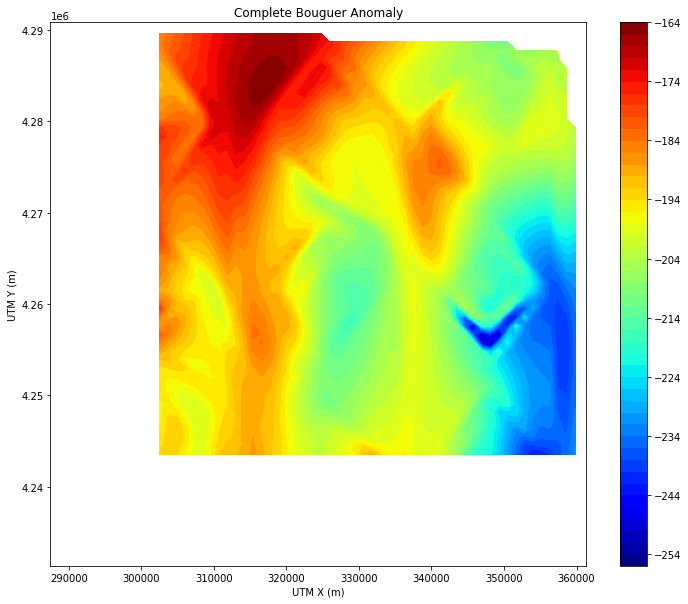

In [0]:
fig, ax = plt.subplots(figsize=(12,10))

# plot CBA contours
im = ax.contourf(xi_mva,yi_mva,zi_cba_mva,levels=50, cmap="jet")
ax.set_title('Complete Bouguer Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
plt.colorbar(im)

Regional Anomaly

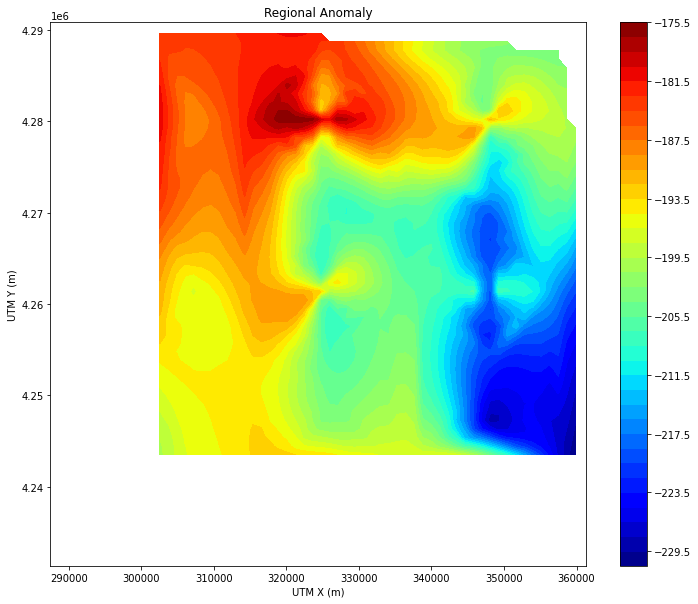

In [0]:
fig, ax = plt.subplots(figsize=(12,10))

# plot regional contours
im = ax.contourf(xi_mva,yi_mva,zi_reg_mva,levels=50, cmap="jet")
ax.set_title('Regional Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
plt.colorbar(im)

Residual Anomaly

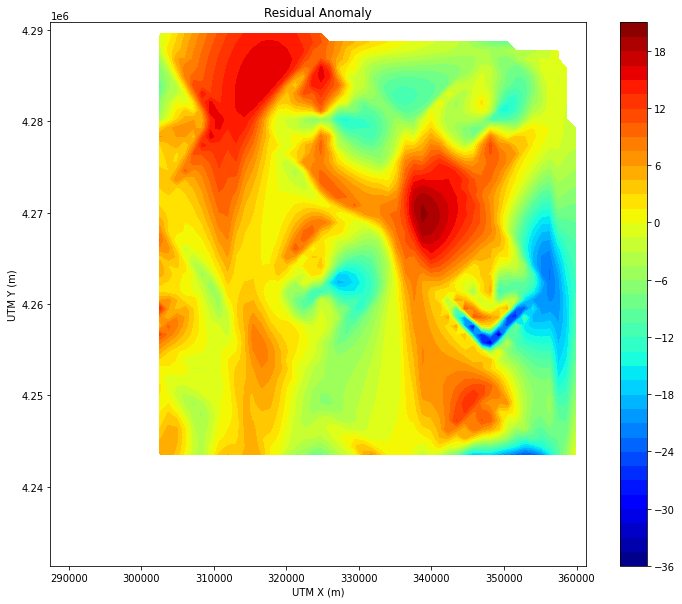

In [0]:
fig, ax = plt.subplots(figsize=(12,10))

# plot residual contours
im = ax.contourf(xi_mva,yi_mva,zi_res_mva,levels=50, cmap="jet")
ax.set_title('Residual Anomaly')
ax.set_xlabel('UTM X (m)'); plt.ylabel('UTM Y (m)')
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
plt.colorbar(im)

## All Anomalies

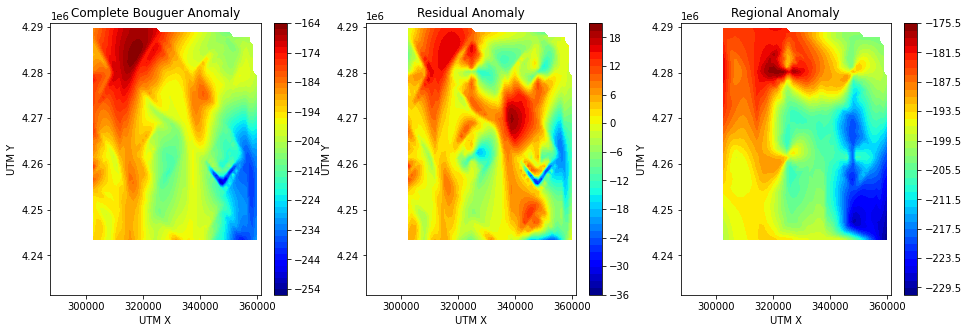

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
axs = axs.flatten()

im = axs[0].contourf(xi_mva,yi_mva,zi_cba_mva,levels=50, cmap="jet")
axs[0].set_title('Complete Bouguer Anomaly')
axs[0].set_xlabel('UTM X'); axs[0].set_ylabel('UTM Y')
axs[0].set_xlim(min_x, max_x)
axs[0].set_ylim(min_y, max_y)
fig.colorbar(im, ax=axs[0])

im = axs[1].contourf(xi_mva,yi_mva,zi_res_mva,levels=50, cmap="jet")
axs[1].set_title('Residual Anomaly')
axs[1].set_xlabel('UTM X'); axs[1].set_ylabel('UTM Y')
axs[1].set_xlim(min_x, max_x)
axs[1].set_ylim(min_y, max_y)
fig.colorbar(im, ax=axs[1])

im = axs[2].contourf(xi_mva,yi_mva,zi_reg_mva,levels=50, cmap="jet")
axs[2].set_title('Regional Anomaly')
axs[2].set_xlabel('UTM X'); axs[2].set_ylabel('UTM Y')
axs[2].set_xlim(min_x, max_x)
axs[2].set_ylim(min_y, max_y)
fig.colorbar(im, ax=axs[2])